In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
from scipy.integrate import odeint
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import warnings 
warnings.filterwarnings('ignore')

### Введение

Процесс распрастранения мнений удобно поделить на две части: распространение информации в сети и изменение мнений участников этой сети о информации 

### SIR подход
Детерминированная модель эпидемии SIR(susceptible - infected - removed) описывает распространение болезни от одного индивида к другому. Участник может находится в трех состояниях: уязвимый, зараженный и невосприимчивый.

Общее количество участников в сети можно ввыыразить как $N(t) = S(t)+I(t)+R(t)$. В модели используются следующие параметры: 
* $\beta$ - частота заражения 
* $\gamma$ - средняя скорость ввыздоровления 

Модель можно представить в виде системы дифференциальных уравнений

$$ 
\begin{cases}
\dot S = - \frac{\beta S I}{N} \\
\dot I = \frac{\beta S I}{N} - \gamma I\\
\dot R = \gamma I\\
\end{cases}
$$

### Модель распространения информации в сети

Существует детерминированная модель Далея-Канделла распространения информации в сети, которая просто является адаптацией SIR-модели. 

Я решил адаптировать эту модель под текущую задачу и получил систему уравнений

$$ 
\begin{cases}
\dot T = \beta A \beta I - \gamma T \\
\dot E = \gamma T\\
\dot A = \alpha E + \alpha I - 2 \beta A\\
\dot I = \beta A + \beta E - \beta I -\alpha I\\
\end{cases}
$$

где
* T - общее число участников популяции без определенного мнения 
* E - люди, которые когда-либо принимали мнение 
* A - агитаторы, которые активно учасивуют в распространении мнений
* I - люди, которые спустя время не принимают участие в распространение мнения 
* $\alpha$ - доля людей, которая приняв мнение начинает его распространять 
* $\beta$ - доля людей для которых мнение становится менее актуальнным
* $\gamma$ - доля людей на которых подействовали агитаторы. Причем этот параметр не является постоянным, а определяется формулой 

  $\gamma = \dfrac {A\times h}{T}$, где $h$ - так называемое число людей на которых может повлиять один агитатор

<img src="Diagram.jpg" style="width: 400px;"/>

In [2]:
def equations(x,time,n):
    T = x[0]
    E = x[1]
    A = x[2]
    I = x[3]
    num_of_handshakes = n
    gamma = A*num_of_handshakes / T
    alpha = 0.2
    beta = 0.01
    mu = 0.1
    dtdt = beta*A+beta*I-gamma*T
    dedt = gamma*T
    dadt = alpha*E + alpha*I - 2*beta*A
    didt = beta*A + beta*E-beta*I - alpha*I
    return [dtdt,dedt,dadt,didt]
def count_rumour_model(num,head,handshakes):
    x0 = [1000,0,10,0]
    num_iterations = num
    time = np.linspace(0,head,num_iterations)
    x = odeint(equations,x0,time,(handshakes,))
    t = x[:,0]
    e = x[:,1]
    a = x[:,2]
    i = x[:,3]
    return(t,e,a,i)

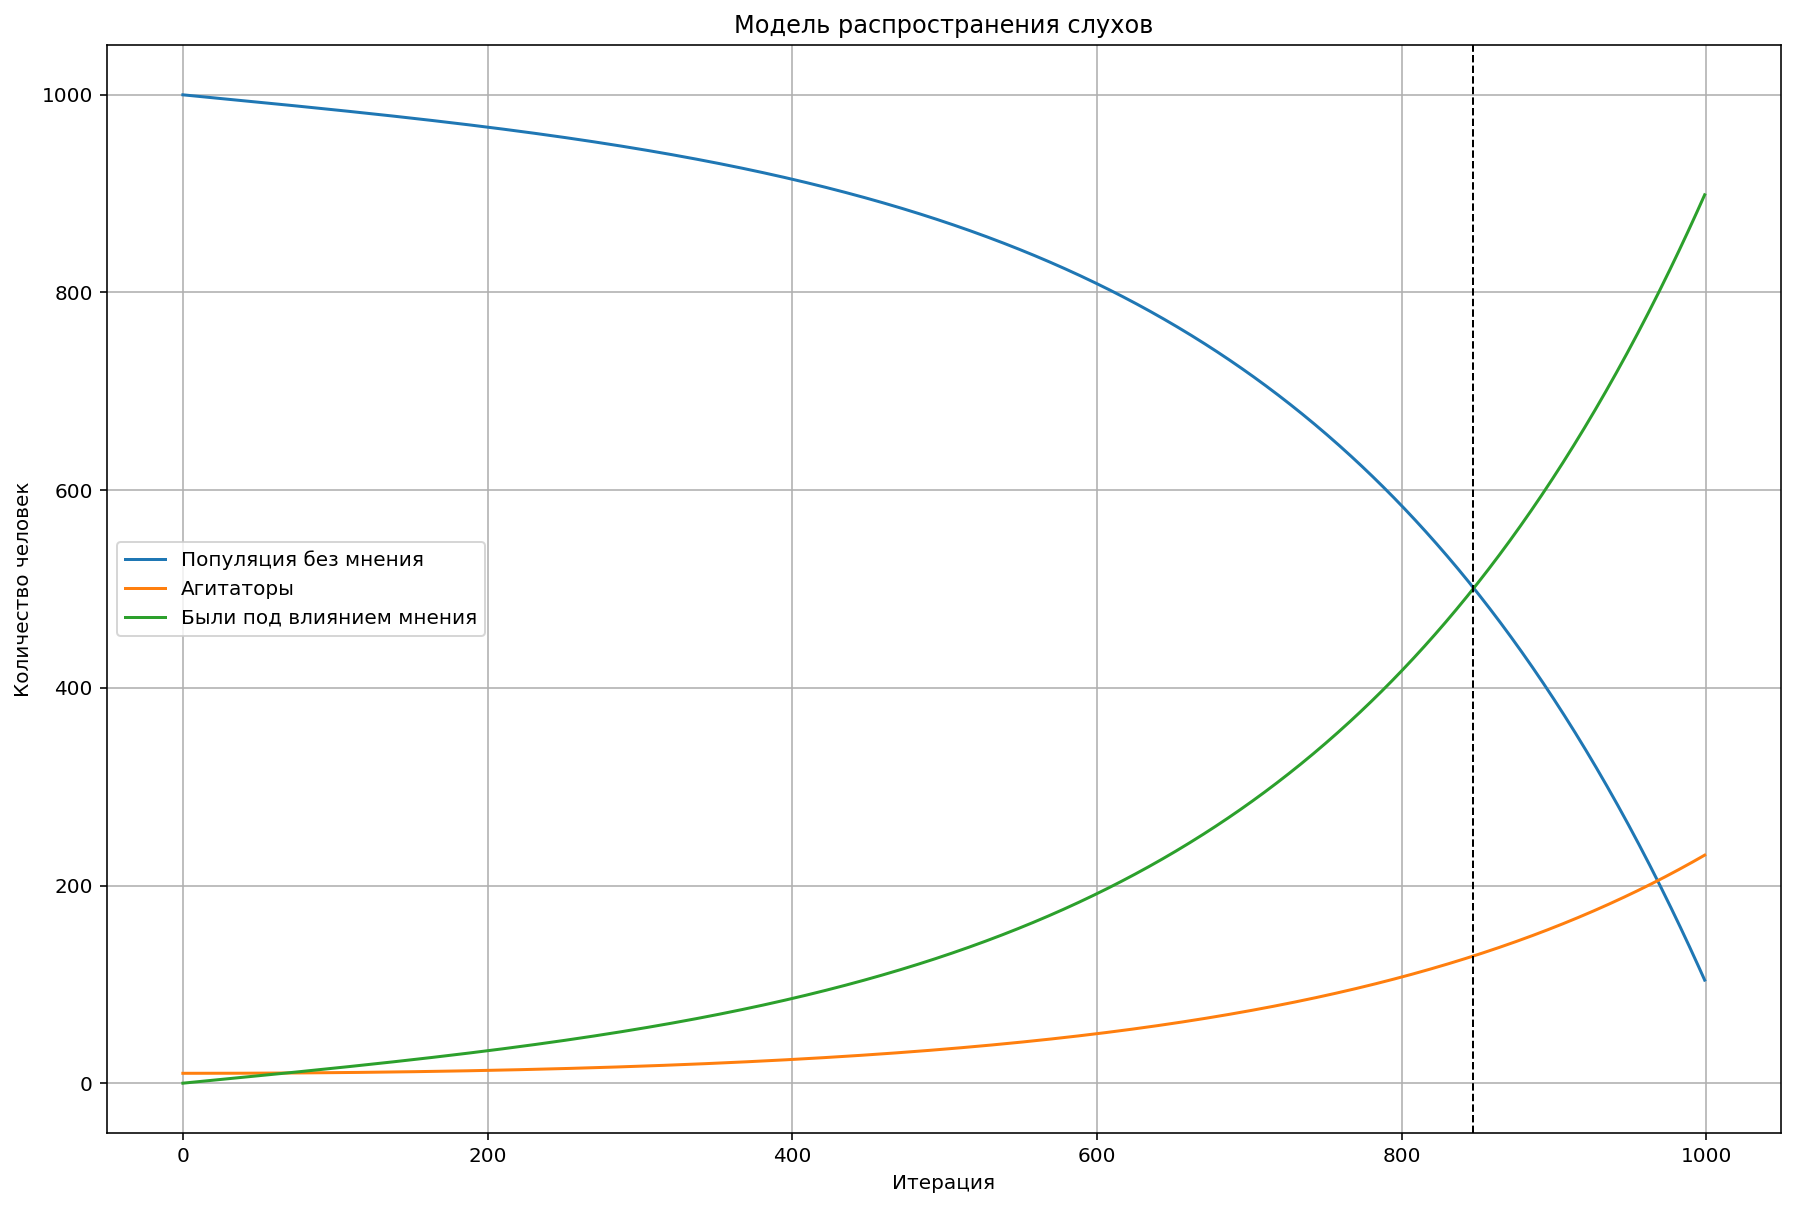

In [4]:
num_iterations = 1000
head = 5
t,e,a,i = count_rumour_model(num_iterations,head,3)
x_range = range(0,num_iterations)
plt.plot(x_range, t, label='Популяция без мнения')
plt.plot(x_range, a,label='Агитаторы')
plt.plot(x_range,e,label = 'Были под влиянием мнения')
plt.xlabel("Итерация")
plt.ylabel("Количество человек")
#plt.yscale('log')
plt.grid(True)
plt.legend(loc="best")
plt.title("Модель распространения слухов")
plt.rcParams["figure.figsize"] = (15, 10)
try:
    idx = np.argwhere(np.diff(np.sign(t - e))).flatten()
    plt.axvline(idx, color='k', linestyle='dashed', linewidth=1)
except: 
    pass
plt.show()

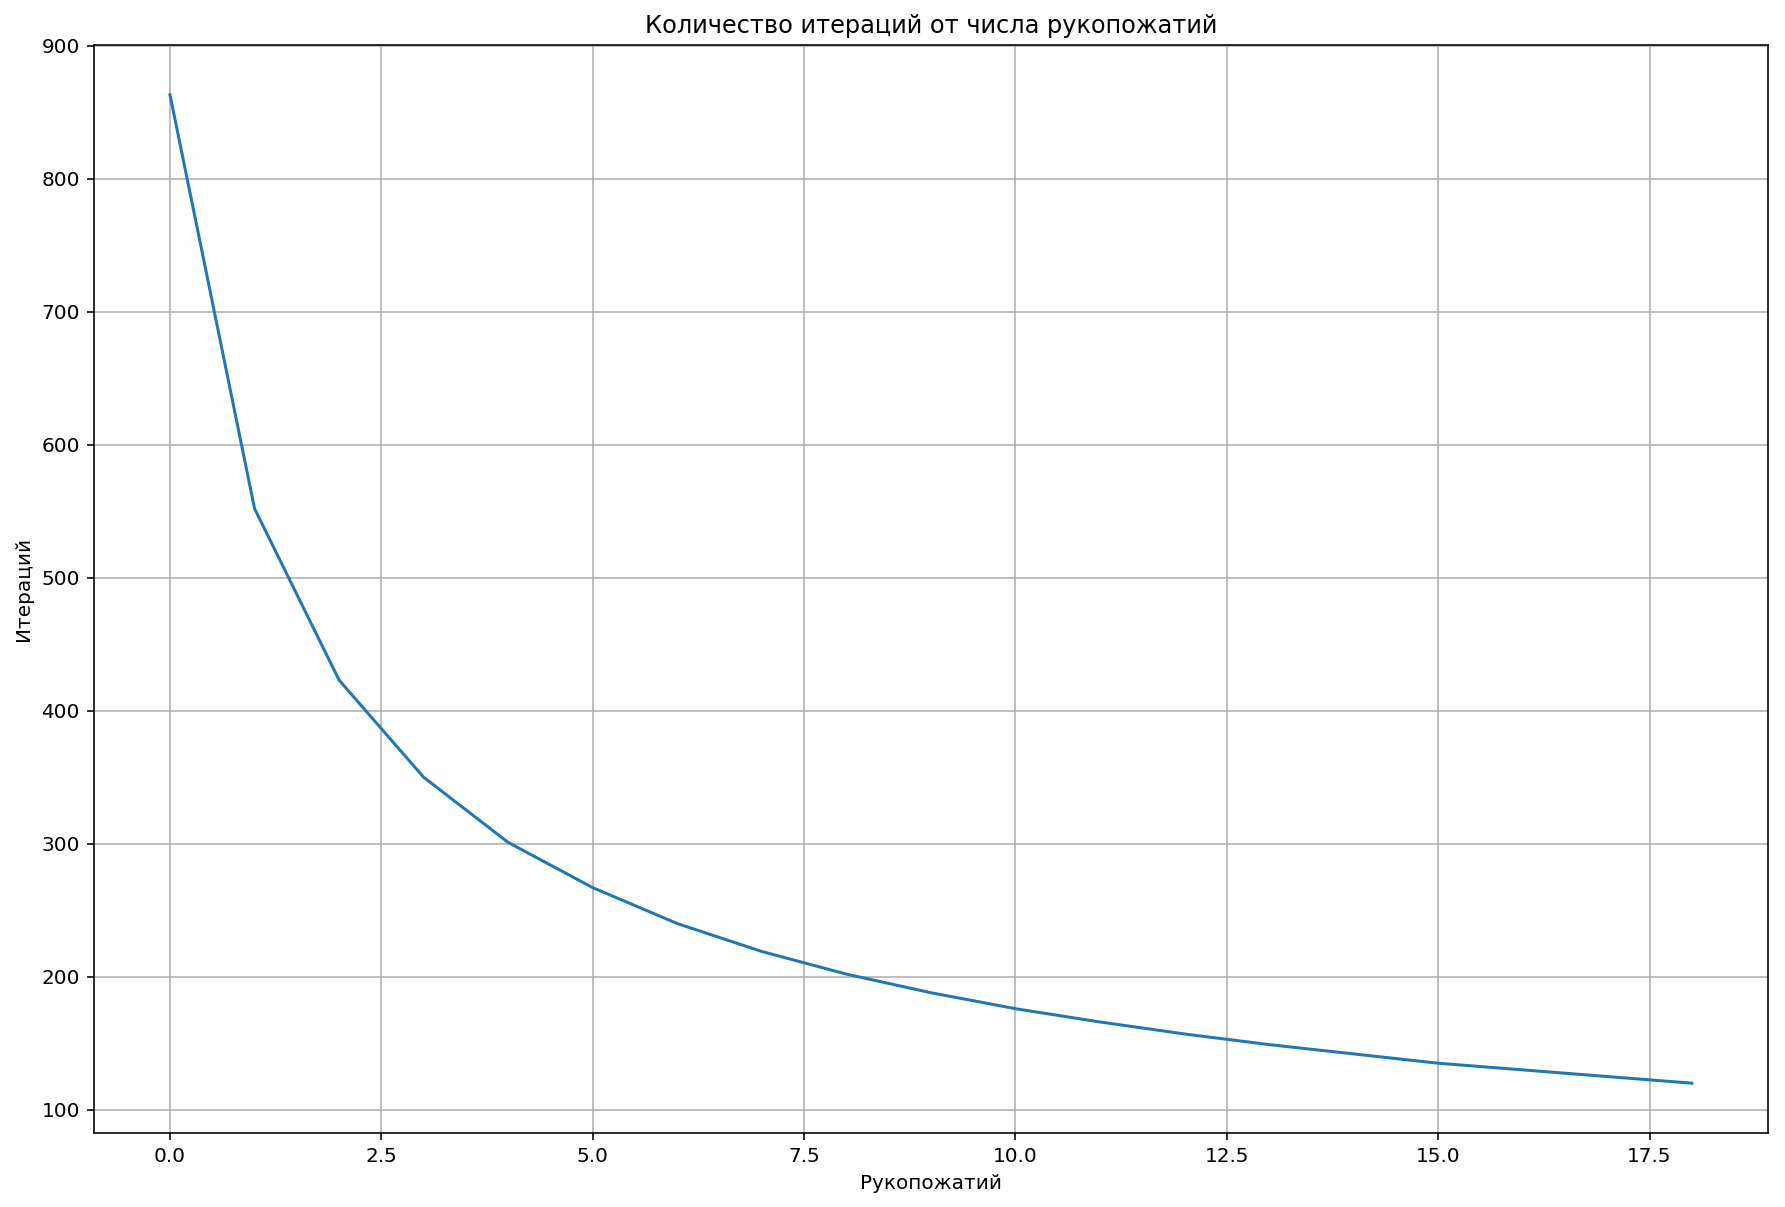

In [5]:
iter_list = list()
for i in range(0,20):
    t,e,a,i = count_rumour_model(1000,10,i)
    idx = np.argwhere(np.diff(np.sign(t - e))).flatten()
    try:
        iter_list.append(idx[0])
    except:
        iter_list.append(0)
# iter_list[0] = 1000
if iter_list[0] == 0:
    iter_list = iter_list[1:]

x_range = range(0,len(iter_list))
plt.plot(x_range,iter_list)
plt.xlabel("Рукопожатий")
plt.ylabel("Итераций")
plt.grid(True)
# plt.legend(loc="best")
plt.title("Количество итераций от числа рукопожатий")
plt.rcParams["figure.figsize"] = (15, 10)
plt.show()

### Марковская модель влияния 

Теперь будем рассматривать модель изменения мнений участников сети об информации. 

Динамика влияний описывается марковским процессом, а мнения рассчитываются с помощью матрицы влияний. 
#### Описание модели 
Учстники социальной сети - множество $N = {1,2,3 ... n}$ 

Участники в сети влияяют друг на друга и это взаимное влияние задается матрицей прямого влияния $A = || \alpha_{ij}||$ размера $n\times n$, где $\alpha_{ij}$ - степень влияния j-го агента на i-го. 

Влияние в сети можно изображать в виде графа. Например


<img src="single_influence.png" style="width: 200px;"/>

$\alpha$ -степень прямого влияния j-го участника сети на i-го. 

Будем считать, что i-ый участник знает только свою строчку матрицы A. Кроме того, будем считать, что выполнено условие нормировки и матрица А является стохастической по строкам

$$
\forall i :  \sum_{j=1}^{n} \alpha_{ij} = 1
$$

Помимо прямого влияния еще сущестует и косвенное. К примеру 


<img src="m_influence.png" style="width: 200px;"/>

Если j-ый участник сети влияет на i-го, а k-ый влияет на j-го, то будем говорить, что k-ый косвенно влияет на i-го

#### Формирование мнений участников сети

Пусть у каждого учатника сети в начальный момент времени имеется собственное мнение. Для простоты мнения участников будут представлять из себя числа из множества $1,2,...,n$. Тогда мнение i-го участника $x_i^{0}$. Начальные мнения всех участников сети можно предстваить в виде вектора-столбца мнений $x^0$ размерности n.

После взаимодействия, участники обмениваются мнениями в заваисимости от того насколько сильно на них влияет тот или иной участник сети и вектор $x^0$ меняется. Будем считать это изменение линейным, т.е. мнение участника в следующий момент времени будет являтся взвешенной суммой мнений агентов, которые на него влияют. 

Если взаимодействие участников сети происходит достаточно долго, то их мнение стабилизируется и сходится к результирующему мнению 


$$
X = A^{\infty}x^0\\
$$
где $x^0$ - вектор начальных мнений, $A^{\infty}$ - матрица результирующего влияния, $X$ - вектор итоговых мнений 

In [6]:
def basic_markov_model(opinion_start,influence,num_of_iterations):
    sum_check = True
    len_check = True
    for line in influence:
        if round(np.sum(line),3) == round(1,3):
            pass
        else:
            print(line)
            print(np.sum(line))
            sum_check = False

    for line in influence:
        if len(line) == len(opinion_start):
            pass
        else:
            len_check = False
    
    if sum_check and len_check:
        influence_matrix = np.linalg.matrix_power(influence, num_of_iterations)
        opinion_res = influence_matrix.dot(opinion_start)
        return(opinion_res)
    elif sum_check:
        print('check your opinion matrix sums')
        return 0
    else:
        print('check your opinion matrix shape')
        return 0


def visualize_opinion_change(result_list):
    number_of_graphs = len(result_list[0])
    total_list = list()
    for i in range(number_of_graphs):
        total_list.append([x.flat[i] for x in result_list])
    x_range = range(0,len(total_list[0]))
    for i in range(number_of_graphs):  
        plt.plot(x_range,total_list[i])
    plt.xlabel("Итераций")
    plt.ylabel("Мнение")
    plt.grid(True)
    plt.title("График изменения мнений")
    plt.rcParams["figure.figsize"] = (15, 10)
    plt.show()

    
def conduct_experiment(opinion_start,influence_matrix,number_of_iterations):
        result_list = list()
        result_list.append(opinion_start)
        for i in range(1,number_of_iterations+1):
            result = basic_markov_model(opinion_start,influence_matrix,i)
            result_list.append(result)
        return result_list

### Пример 1
Три участника в сети. Участник доверяет (на участника влияют) другим участникам сети с некоторой положительной вероятностью, которые никому кроме себя не доверяют.

Мнение участника будет стремится к мнению других агентов

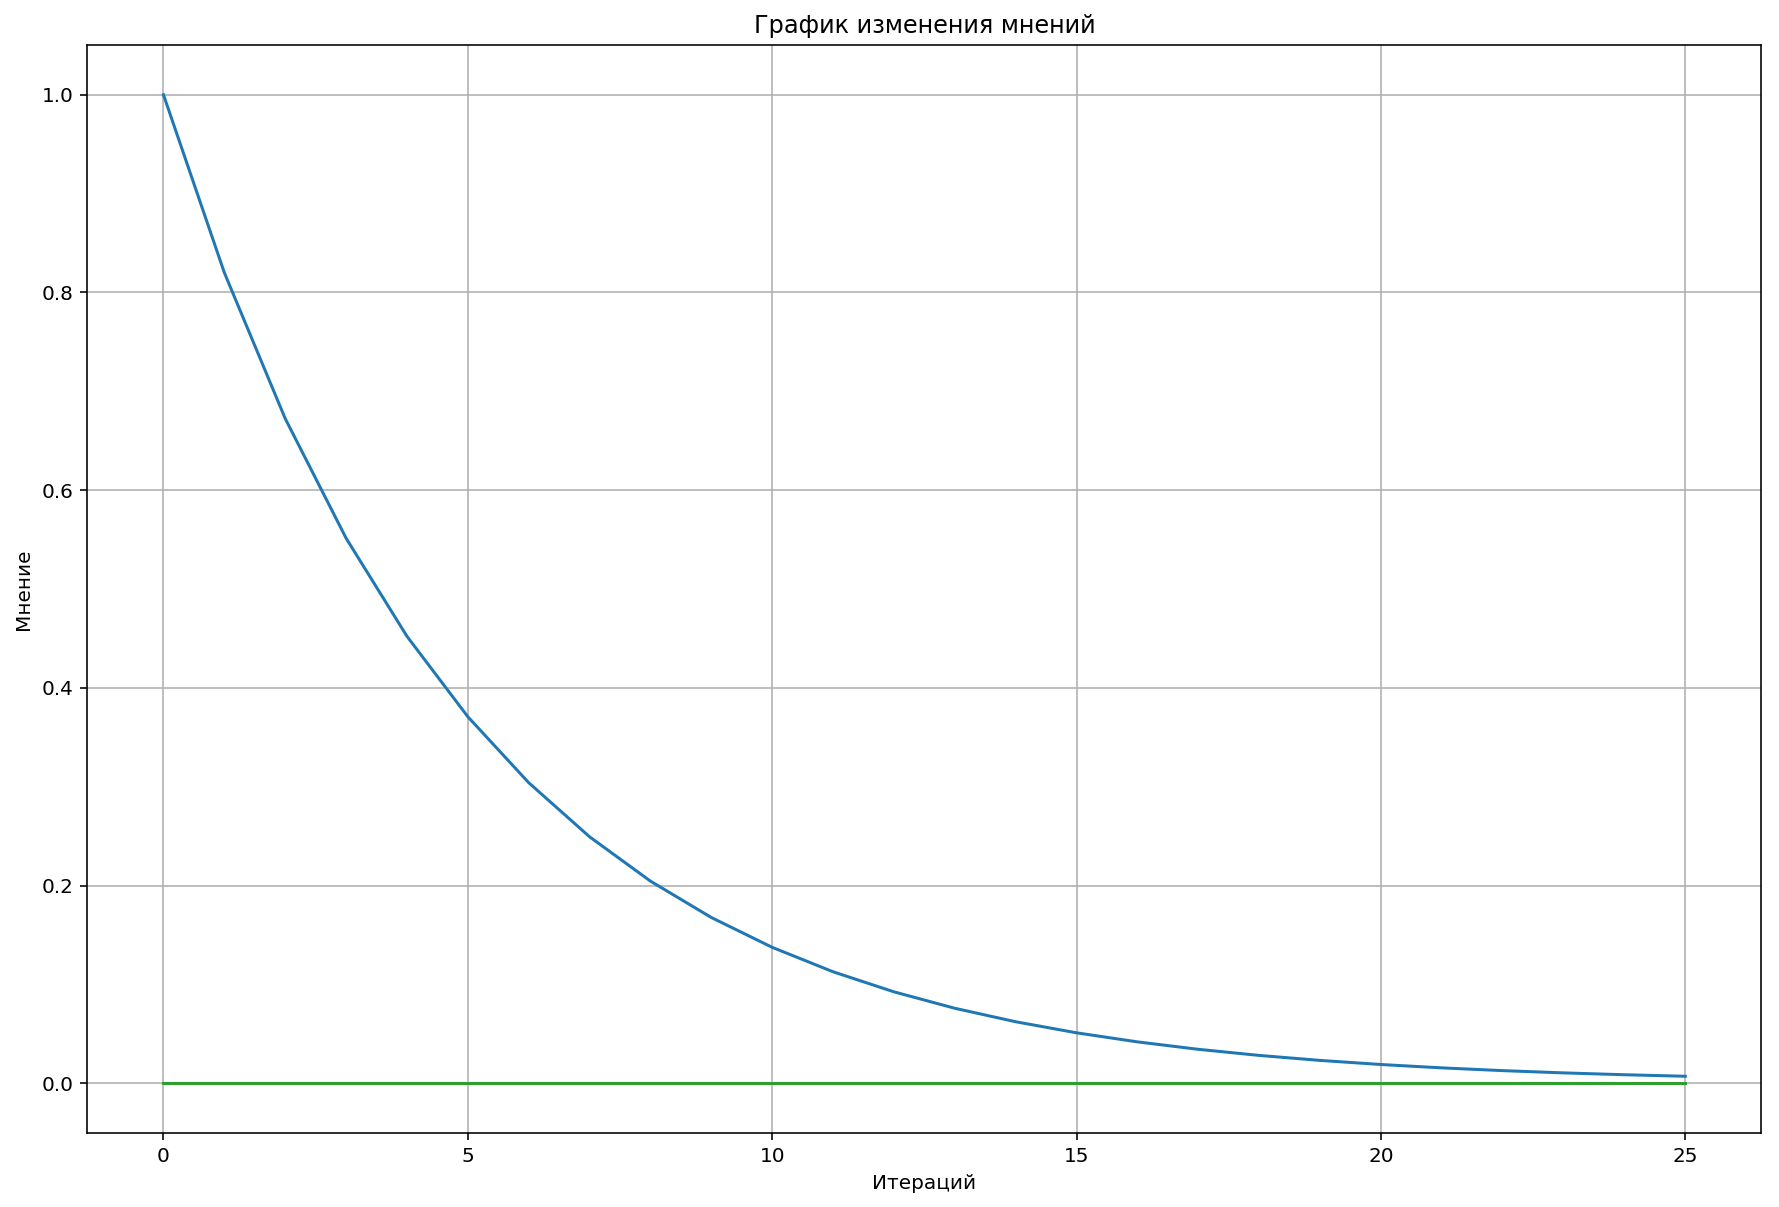

In [7]:
opinion_start = np.array([1,0,0])
influence_matrix = np.array([[0.82,0.09,0.09],[0,1,0],[0,0,1]])
number_of_iterations = 25
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 2
Два участника в сети. Каждый из участников полностью доверяет другому участнику

Мнение участников будет менятся при каждом взаимодействии 

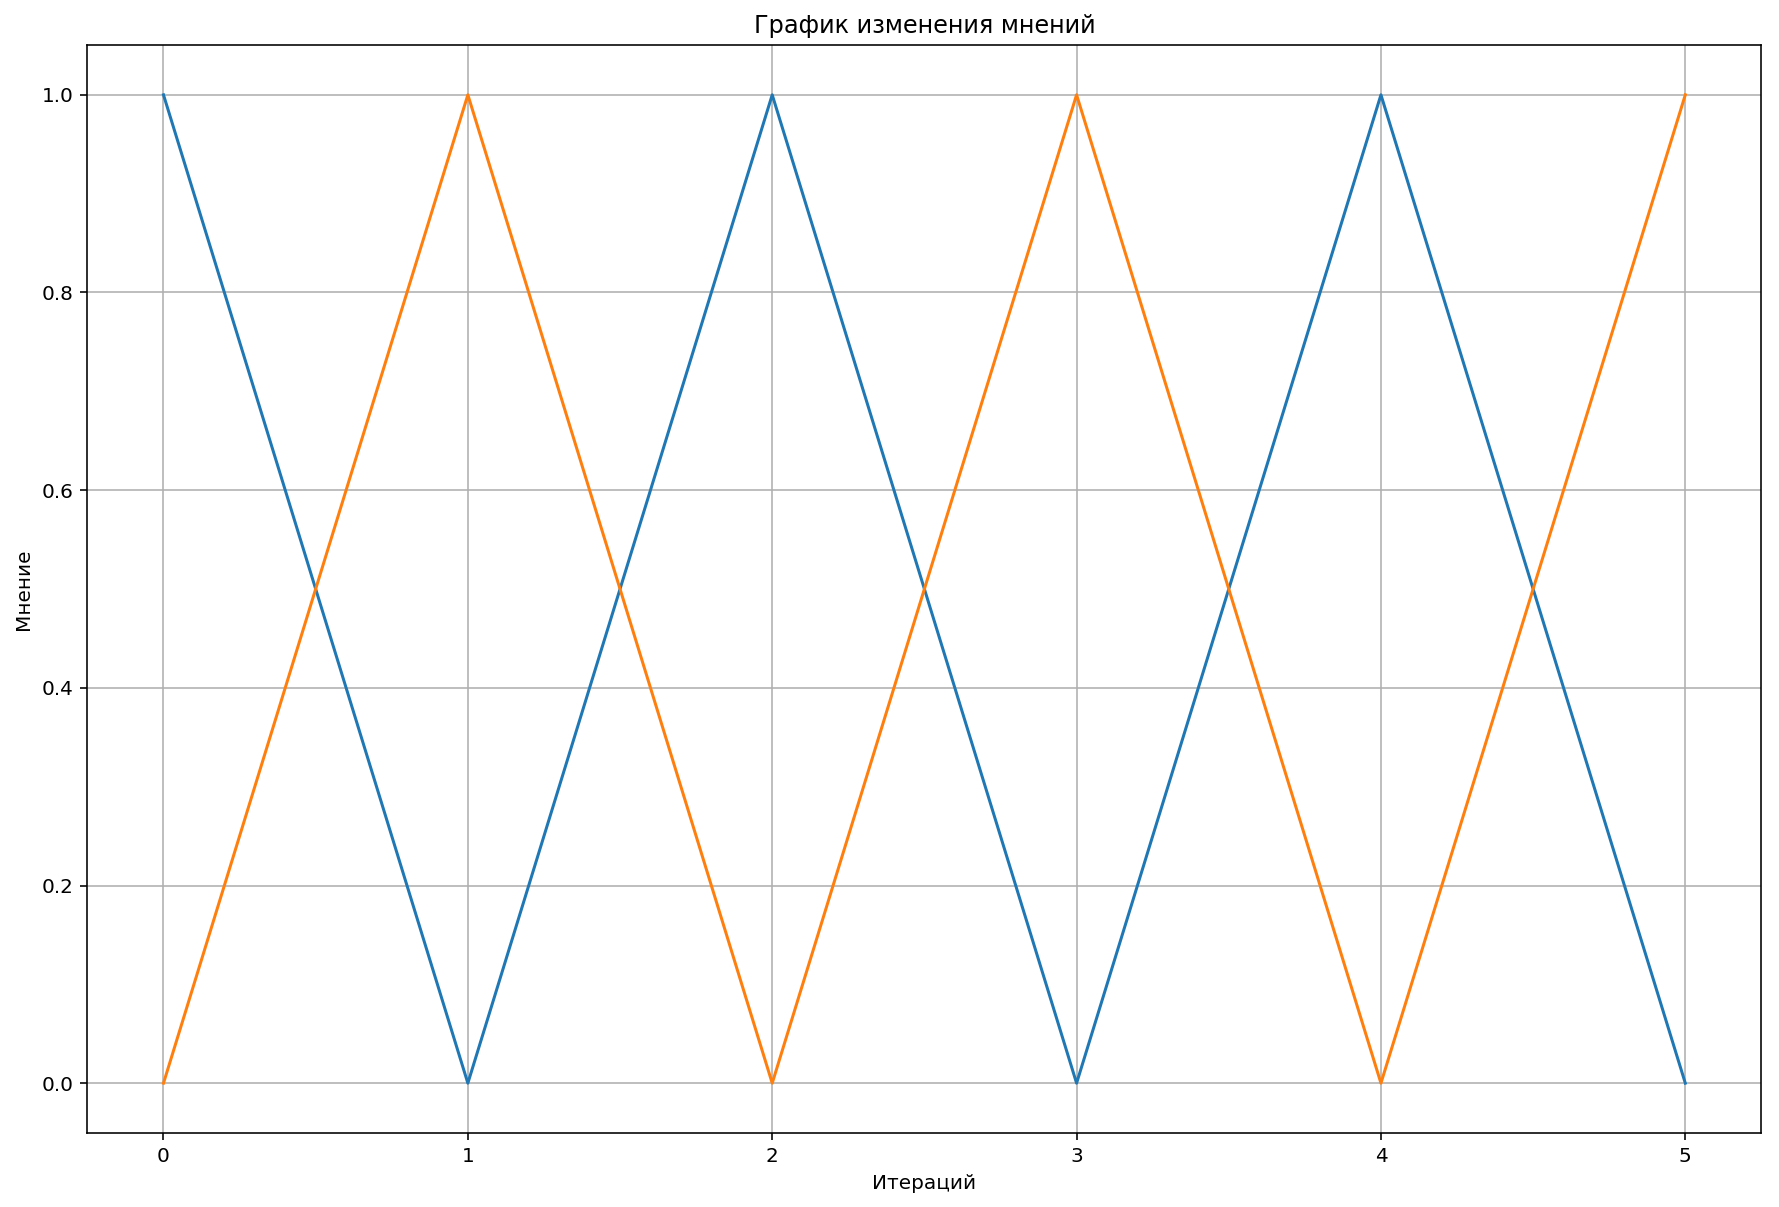

In [8]:
opinion_start = np.array([1,0])
influence_matrix = np.array([[0,1],[1,0]])
number_of_iterations = 5
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 3
Два участника в сети. Каждый из участников доверяет другому участнику с вероятностью $<1$, но при этом каждый из участников доверяет себе с вероятностью $>0$

Мнение участников сойдется к мнению "по середине"

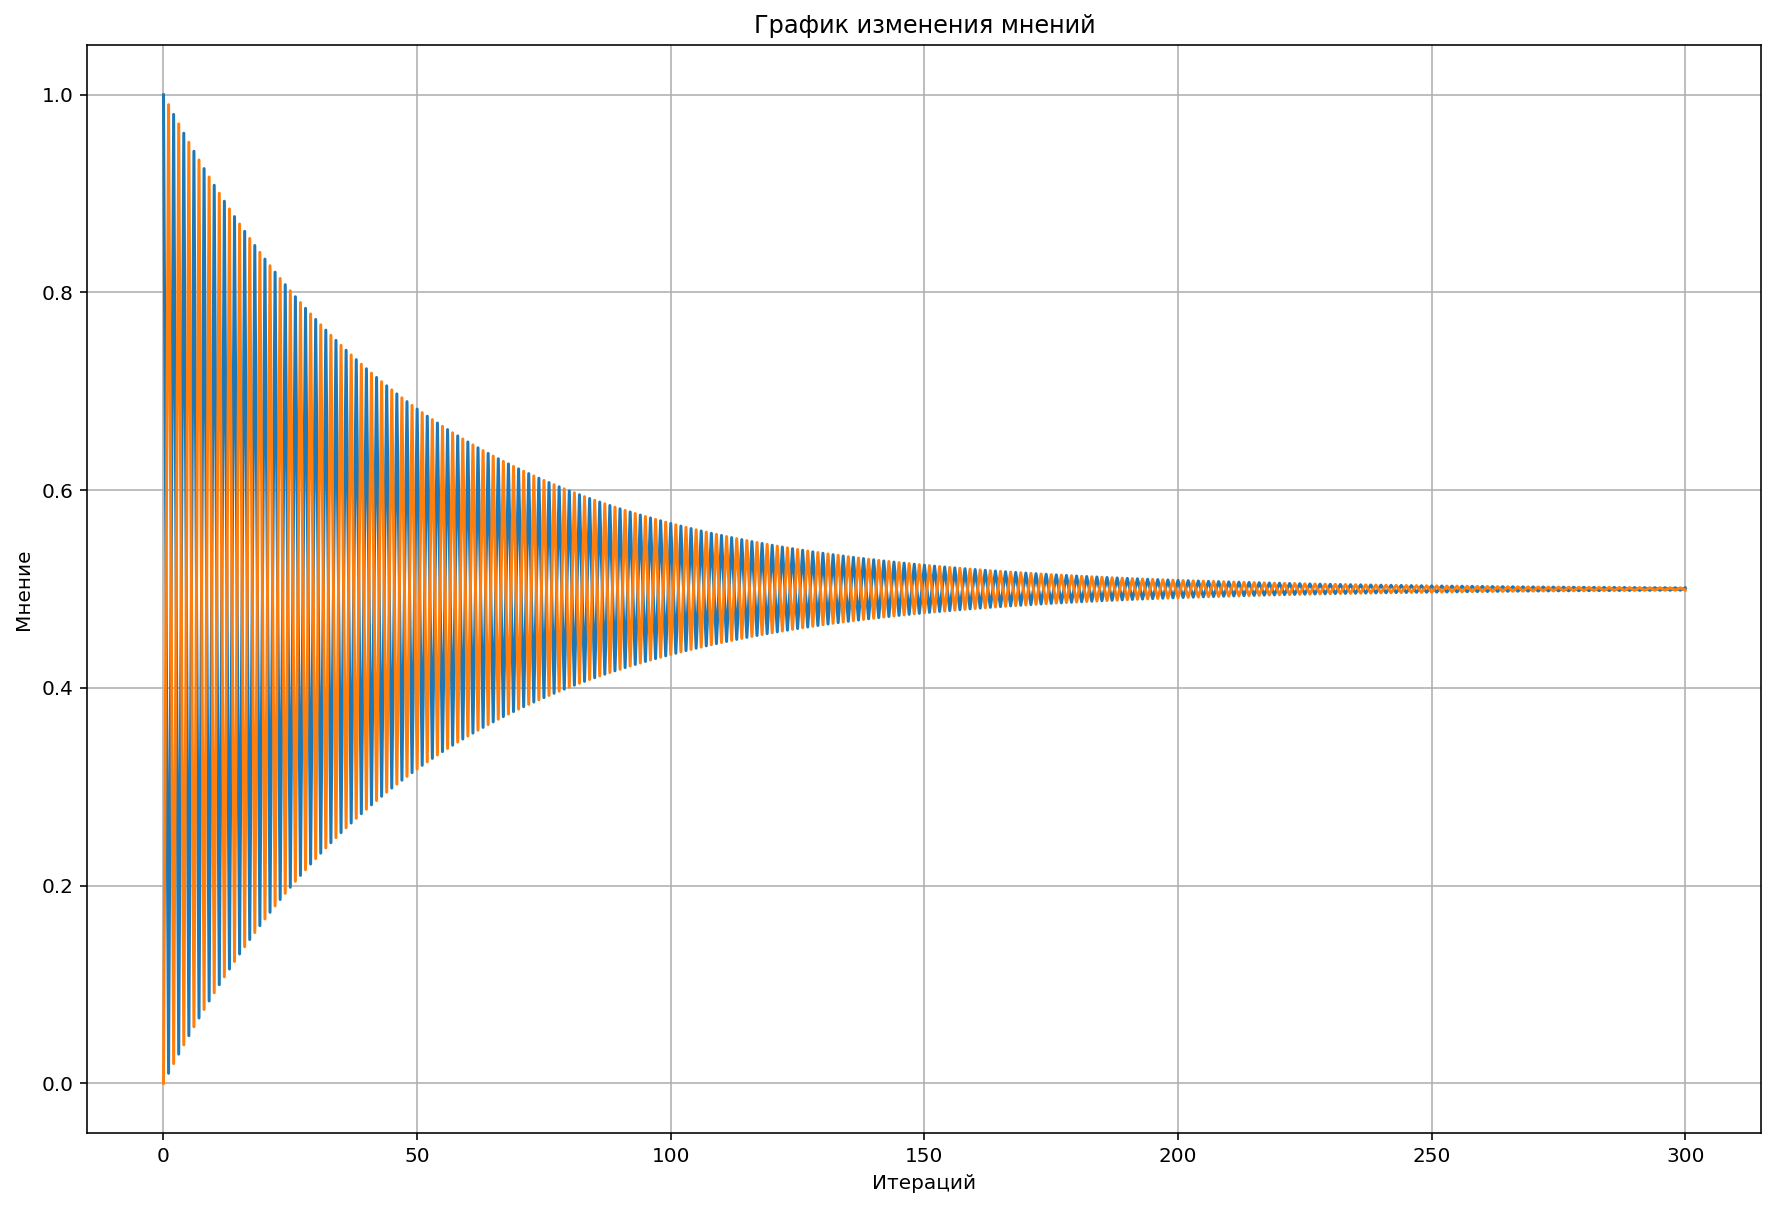

In [9]:
opinion_start = np.array([1,0])
influence_matrix = np.array([[0.01,0.99],[0.99,0.01]])
number_of_iterations = 300
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 4
50 участников в сети. Пусть социальная сеть - полный граф, а степени доверия агентов к себе и всем остальным одинаковы

Итоговое мнение участников будет единым для всех и будет стремится к среднему 

result opinion 24.5


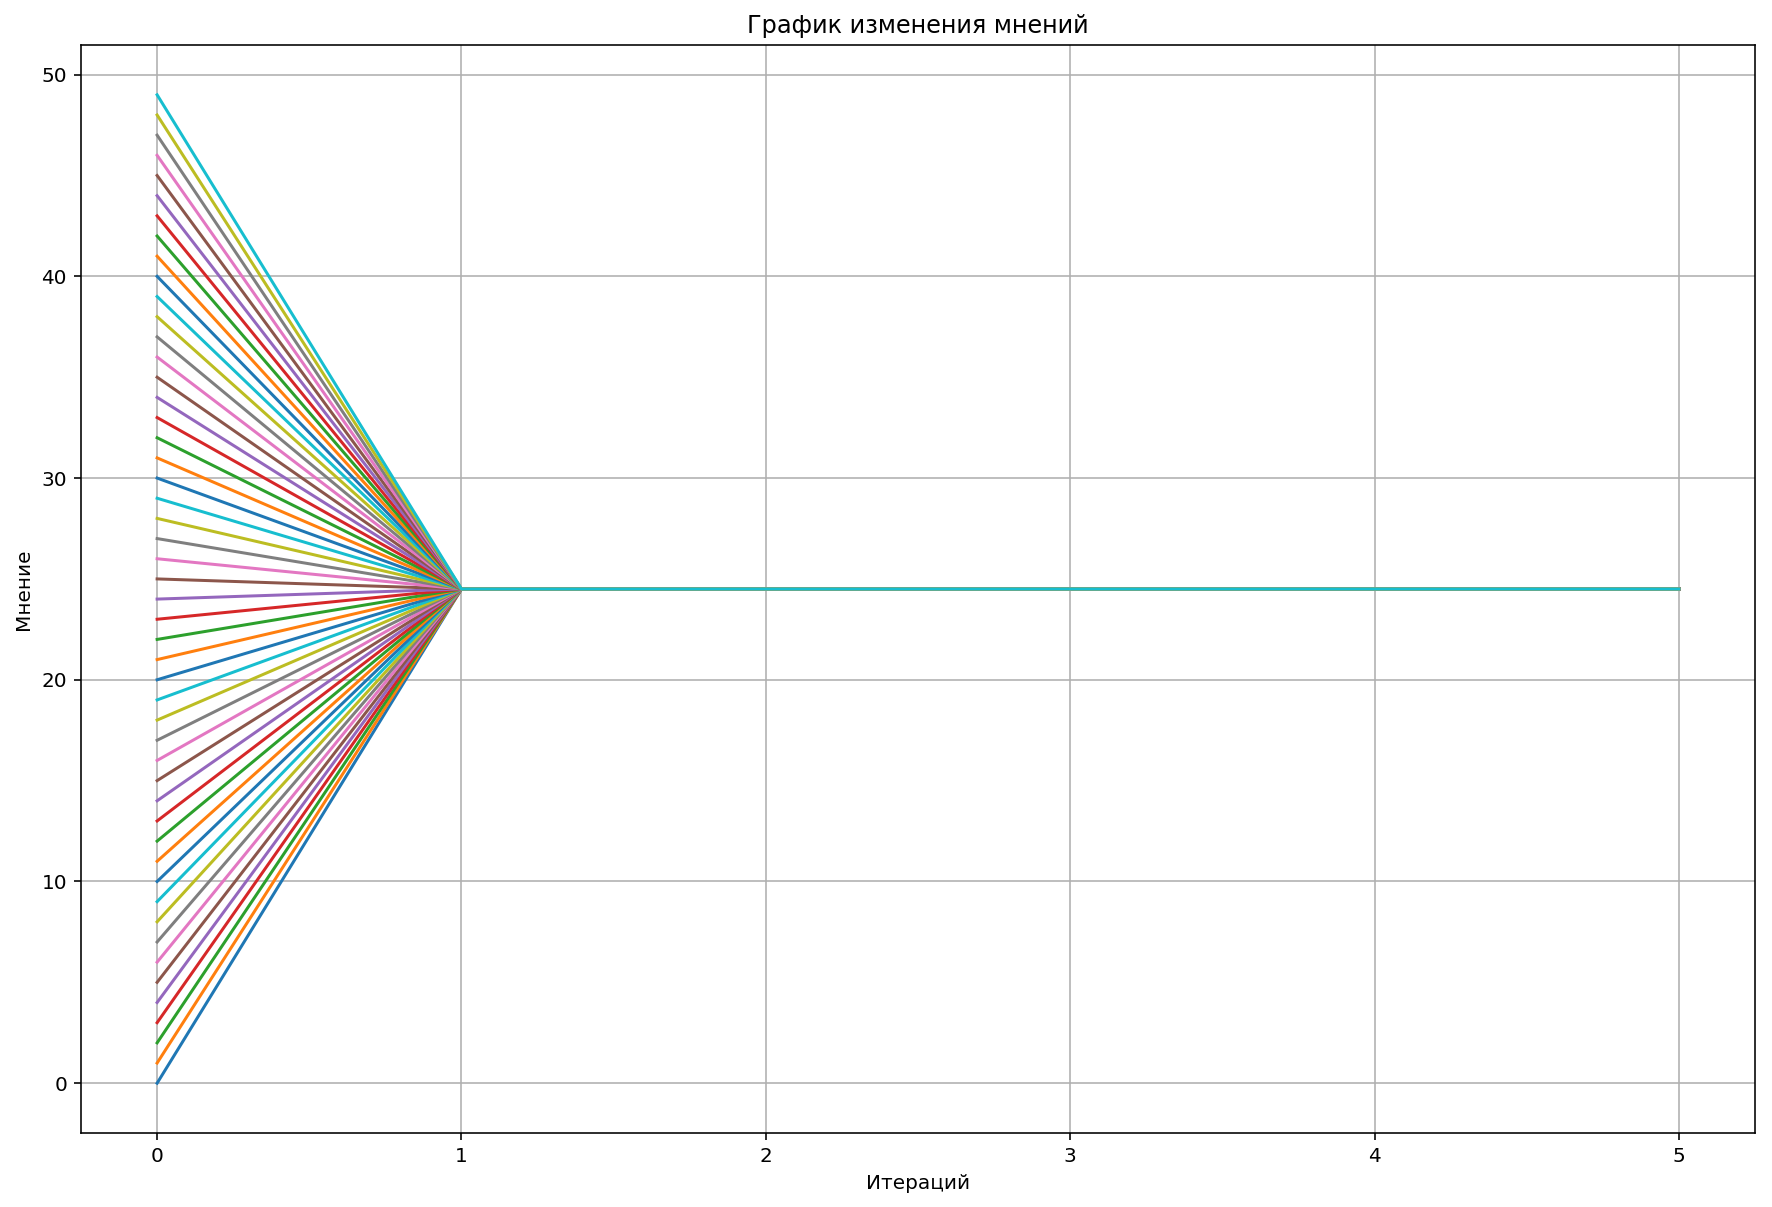

In [10]:
size_of_network = 50
opinion_start = np.arange(size_of_network)
influence_constant = 1 / size_of_network
influence_matrix = np.full(shape=(size_of_network,size_of_network),fill_value=influence_constant)
number_of_iterations = 5
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
print('result opinion {}'.format(np.mean(opinion_start)))
visualize_opinion_change(result)

### Пример 5
50 участников в сети. Пусть социальная сеть - линеная цепочка участников. Первый участник доверяет только себе, каждый из отсальных доверяет себе и своему предшественнику в цепи $\alpha_{i,i-1} = 0.5$

Мнение i-го участника в момент итерации $t$ будет равным $$x_{i}^{t} = 0.5x_{i}^{t-1} + 0.5x_{i-1}^{t-1}$$


Итоговое мнение участников будет единым для всех

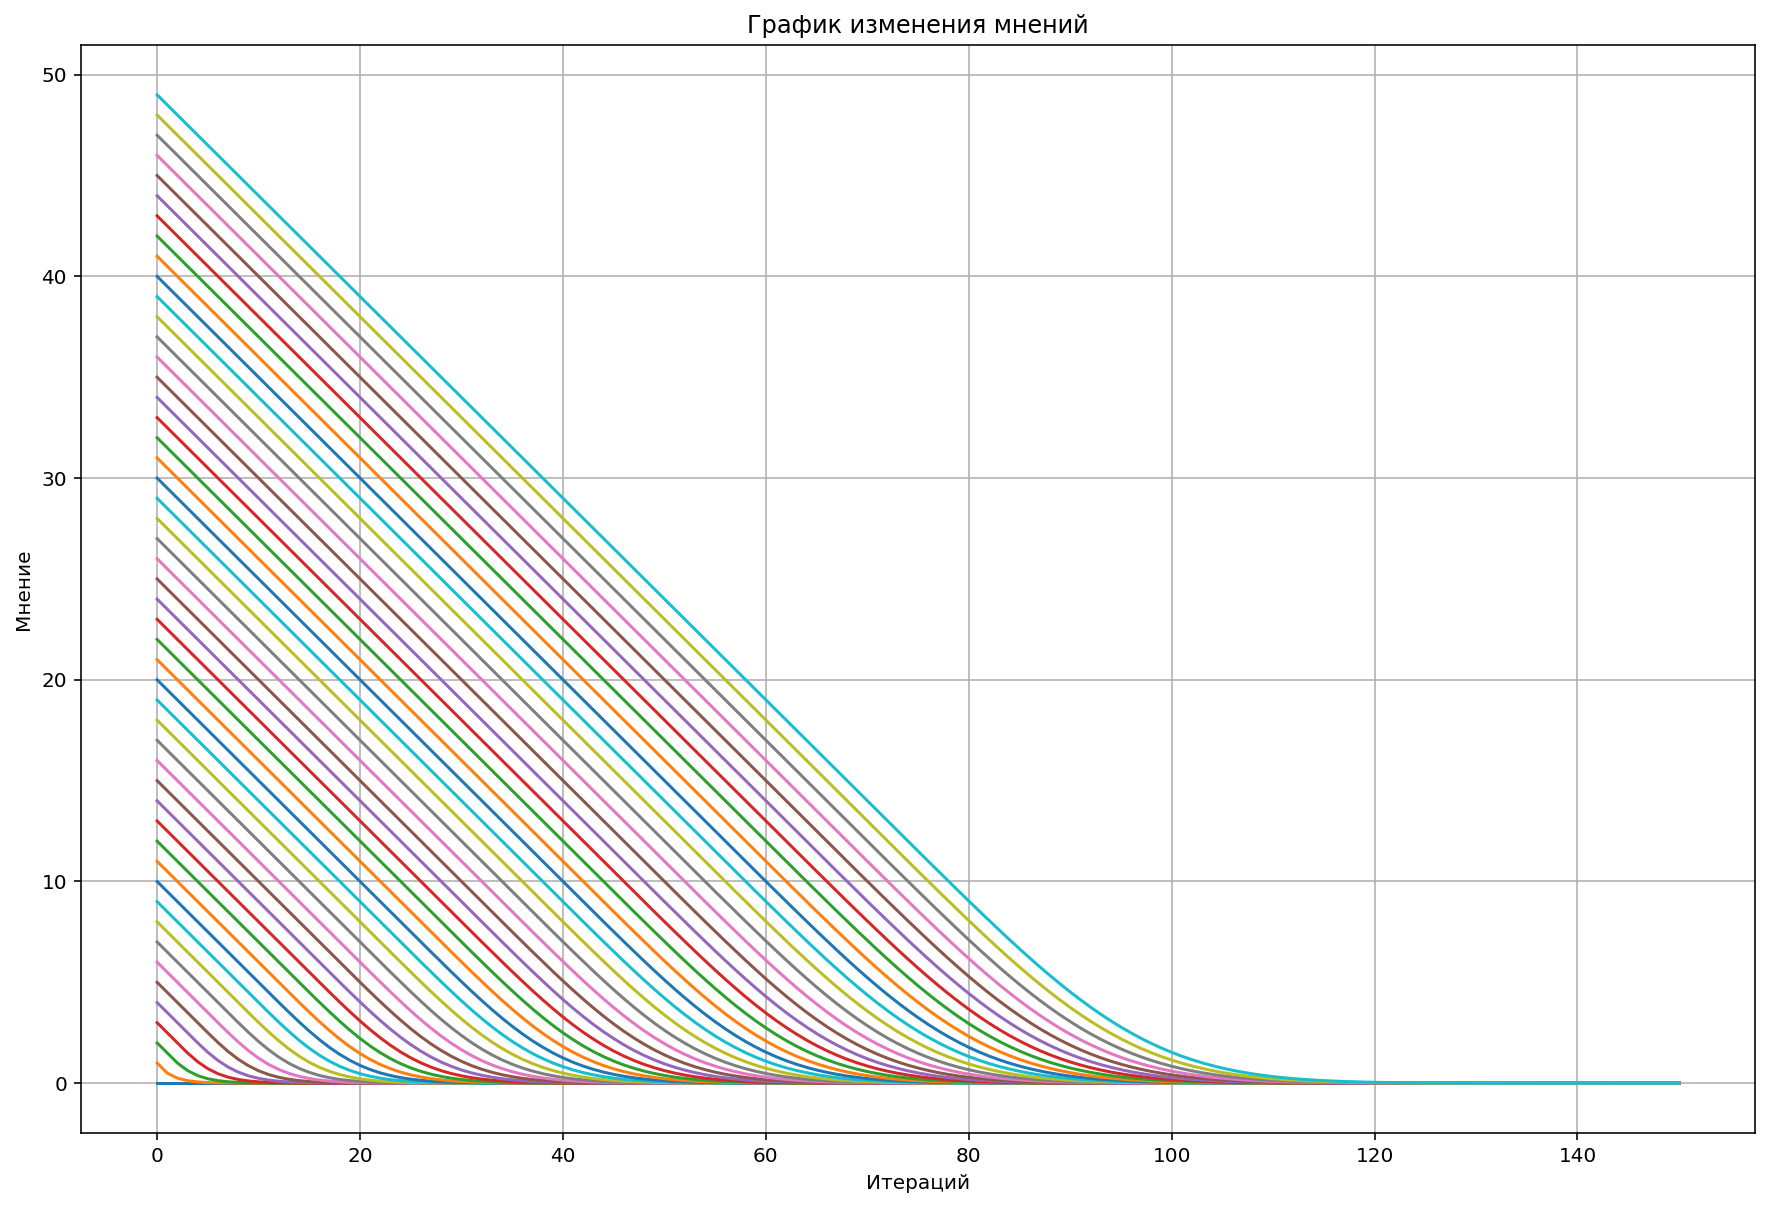

In [11]:
size_of_network = 50
opinion_start = np.arange(size_of_network)
influence_matrix = np.full(shape=(size_of_network,size_of_network),fill_value=0,dtype=float)
np.fill_diagonal(influence_matrix, influence_matrix.diagonal() + 0.5)
for i in range(size_of_network):
    try:
        influence_matrix[i][i-1] = 0.5
    except:
        pass
influence_matrix[0][size_of_network-1] = 0
influence_matrix[0][0] = 1
number_of_iterations = 150
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 6
50 участников в сети. 

Пусть социальная сеть - линейная цепочка участников. 

* Первый участник доверяет себе и $\alpha_{1,2} = 0.5$
* n-ый участник доверяет себе и $\alpha_{n,n-1} = 0.5$
* Каждый из остальных доверяет себе с $\alpha_{i,i} = 0.5$, предыдущему с $\alpha_{i,i-1} = 0.25$ и последующему $\alpha_{i,i+1} = 0.25$



Итоговое мнение участников будет единым для всех будет равным $$X = \frac{1}{n-1} (0.5x_{1}^{0} + 0.5x_{n}^{0} + \sum_{i=2}^{n-1}x_i^0)$$

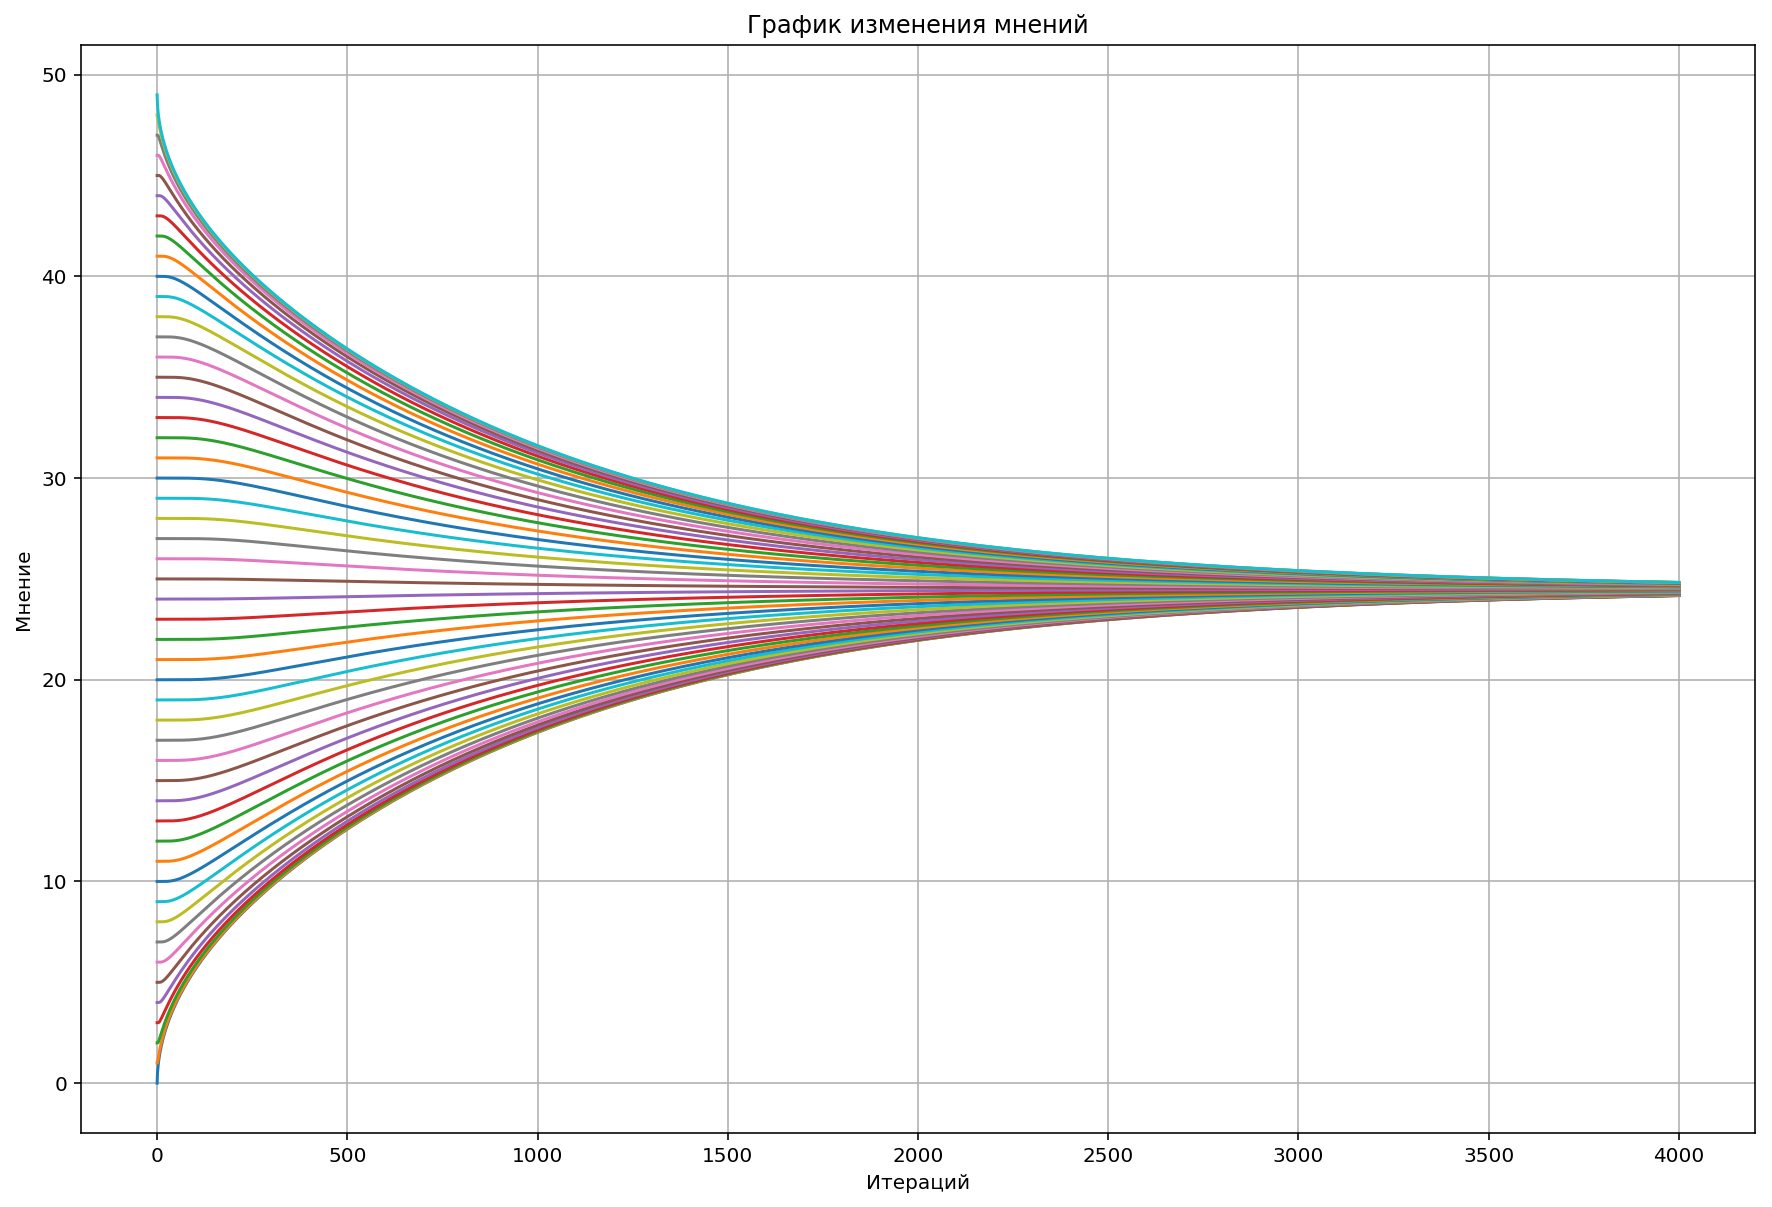

In [12]:
size_of_network = 50
opinion_start = np.arange(size_of_network)
influence_matrix = np.full(shape=(size_of_network,size_of_network),fill_value=0,dtype=float)
np.fill_diagonal(influence_matrix, influence_matrix.diagonal() + 0.5)
for i in range(size_of_network):
    try:
        influence_matrix[i][i-1] = 0.25
        influence_matrix[i][i+1] = 0.25
    except:
        pass
influence_matrix[0][size_of_network-1] = 0
influence_matrix[0][1] = 0.5
influence_matrix[size_of_network-1][size_of_network-2] = 0.5
number_of_iterations = 4000
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 7
50 участников в сети. 

Пусть социальная сеть - кольцо

* Каждый из остальных доверяет себе с $\alpha_{i,i} = 0.5$  и последующему $\alpha_{i,i+1} = 0.5$



Итоговое мнение участников будет единым для всех будет равным $$X = \frac{1}{n} \sum_{i=1}^{n}x_i^0$$

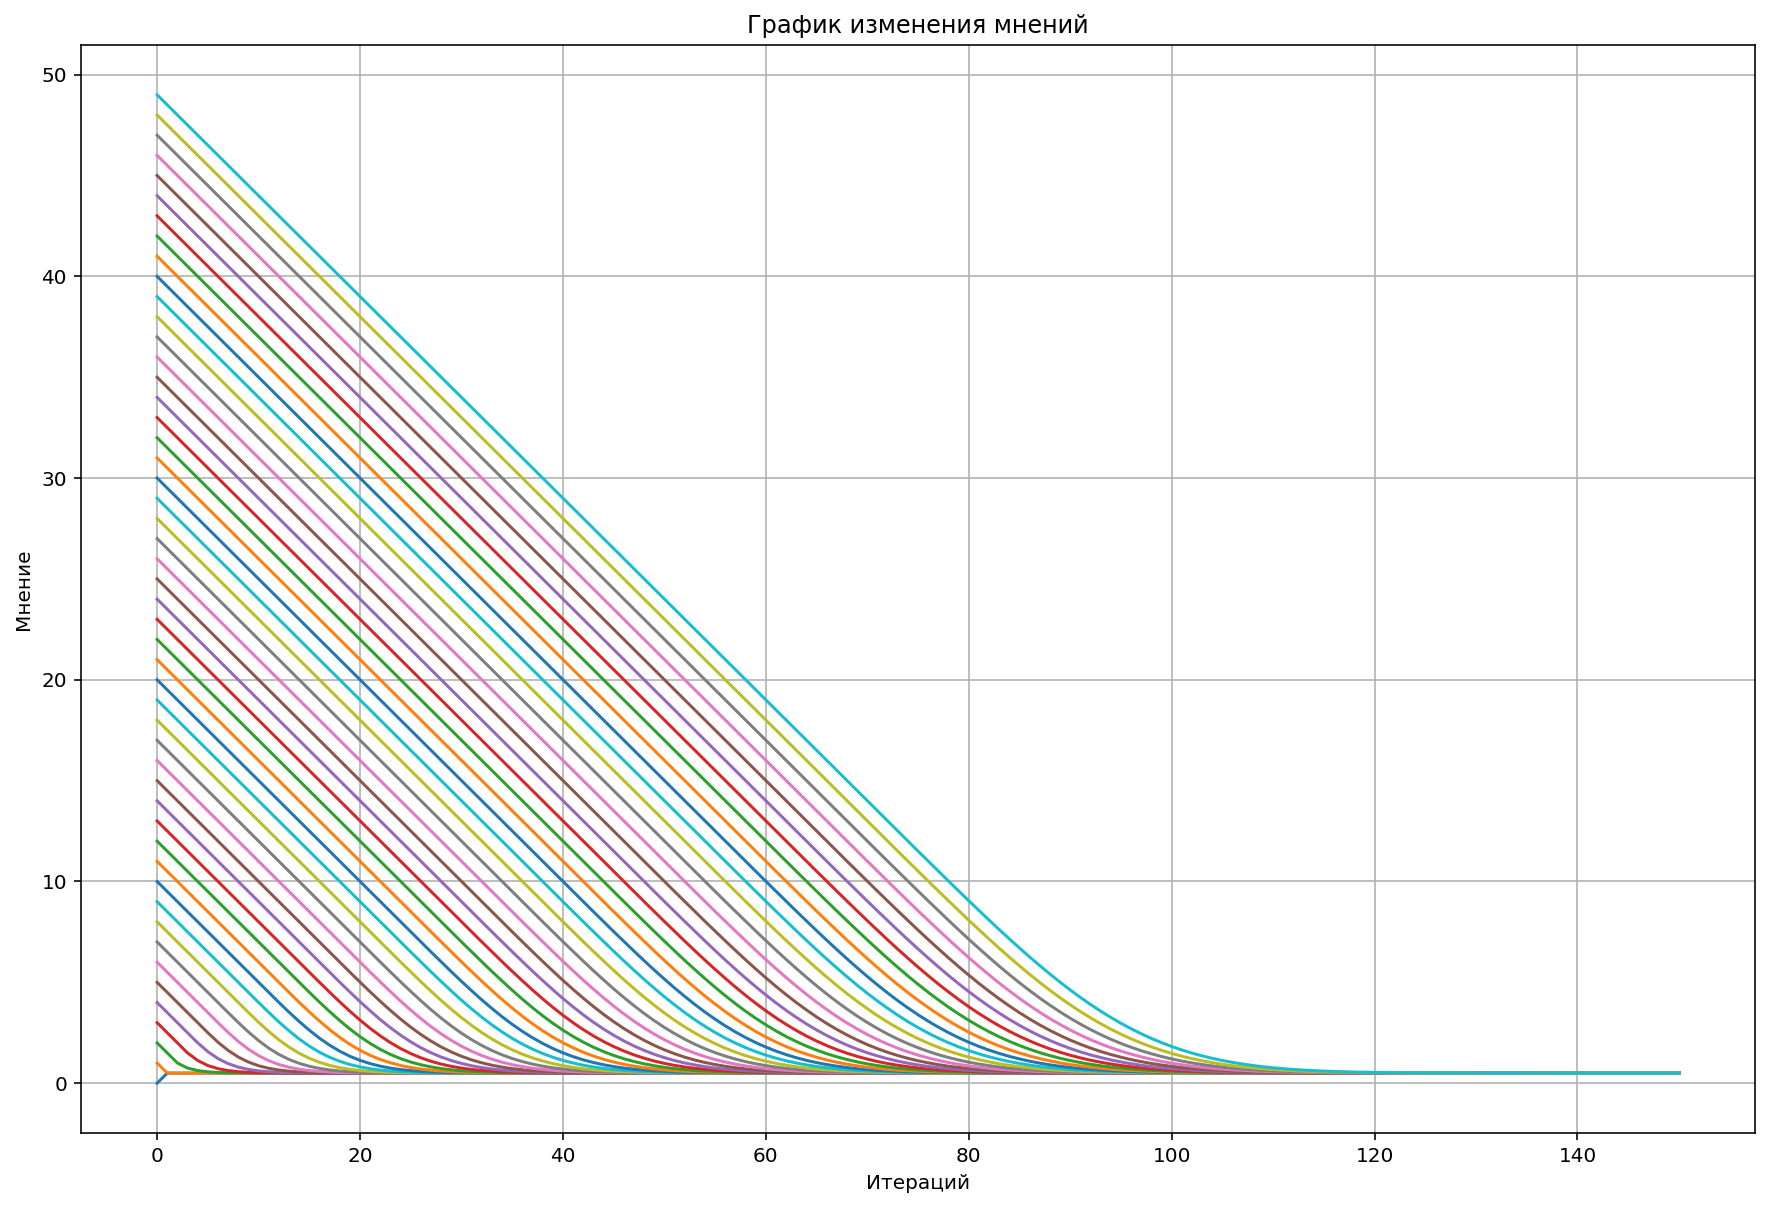

In [13]:
size_of_network = 50
opinion_start = np.arange(size_of_network)
influence_matrix = np.full(shape=(size_of_network,size_of_network),fill_value=0,dtype=float)
np.fill_diagonal(influence_matrix, influence_matrix.diagonal() + 0.5)
for i in range(size_of_network):
    try:
        influence_matrix[i][i-1] = 0.5
    except:
        pass
influence_matrix[0][size_of_network-1] = 0
influence_matrix[0][1] = 0.5
# print(influence_matrix)
number_of_iterations = 150
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 8
50 участников в сети. 

Пусть социальная сеть - кольцо

* Каждый из остальных доверяет себе с $\alpha_{i,i} = 0.5$, последующему $\alpha_{i,i+1} = 0.25$ и предыдущему $\alpha_{i,i-1} = 0.25$


Итоговое мнение участников будет единым для всех будет равным $$X = \frac{1}{n} \sum_{i=1}^{n}x_i^0$$

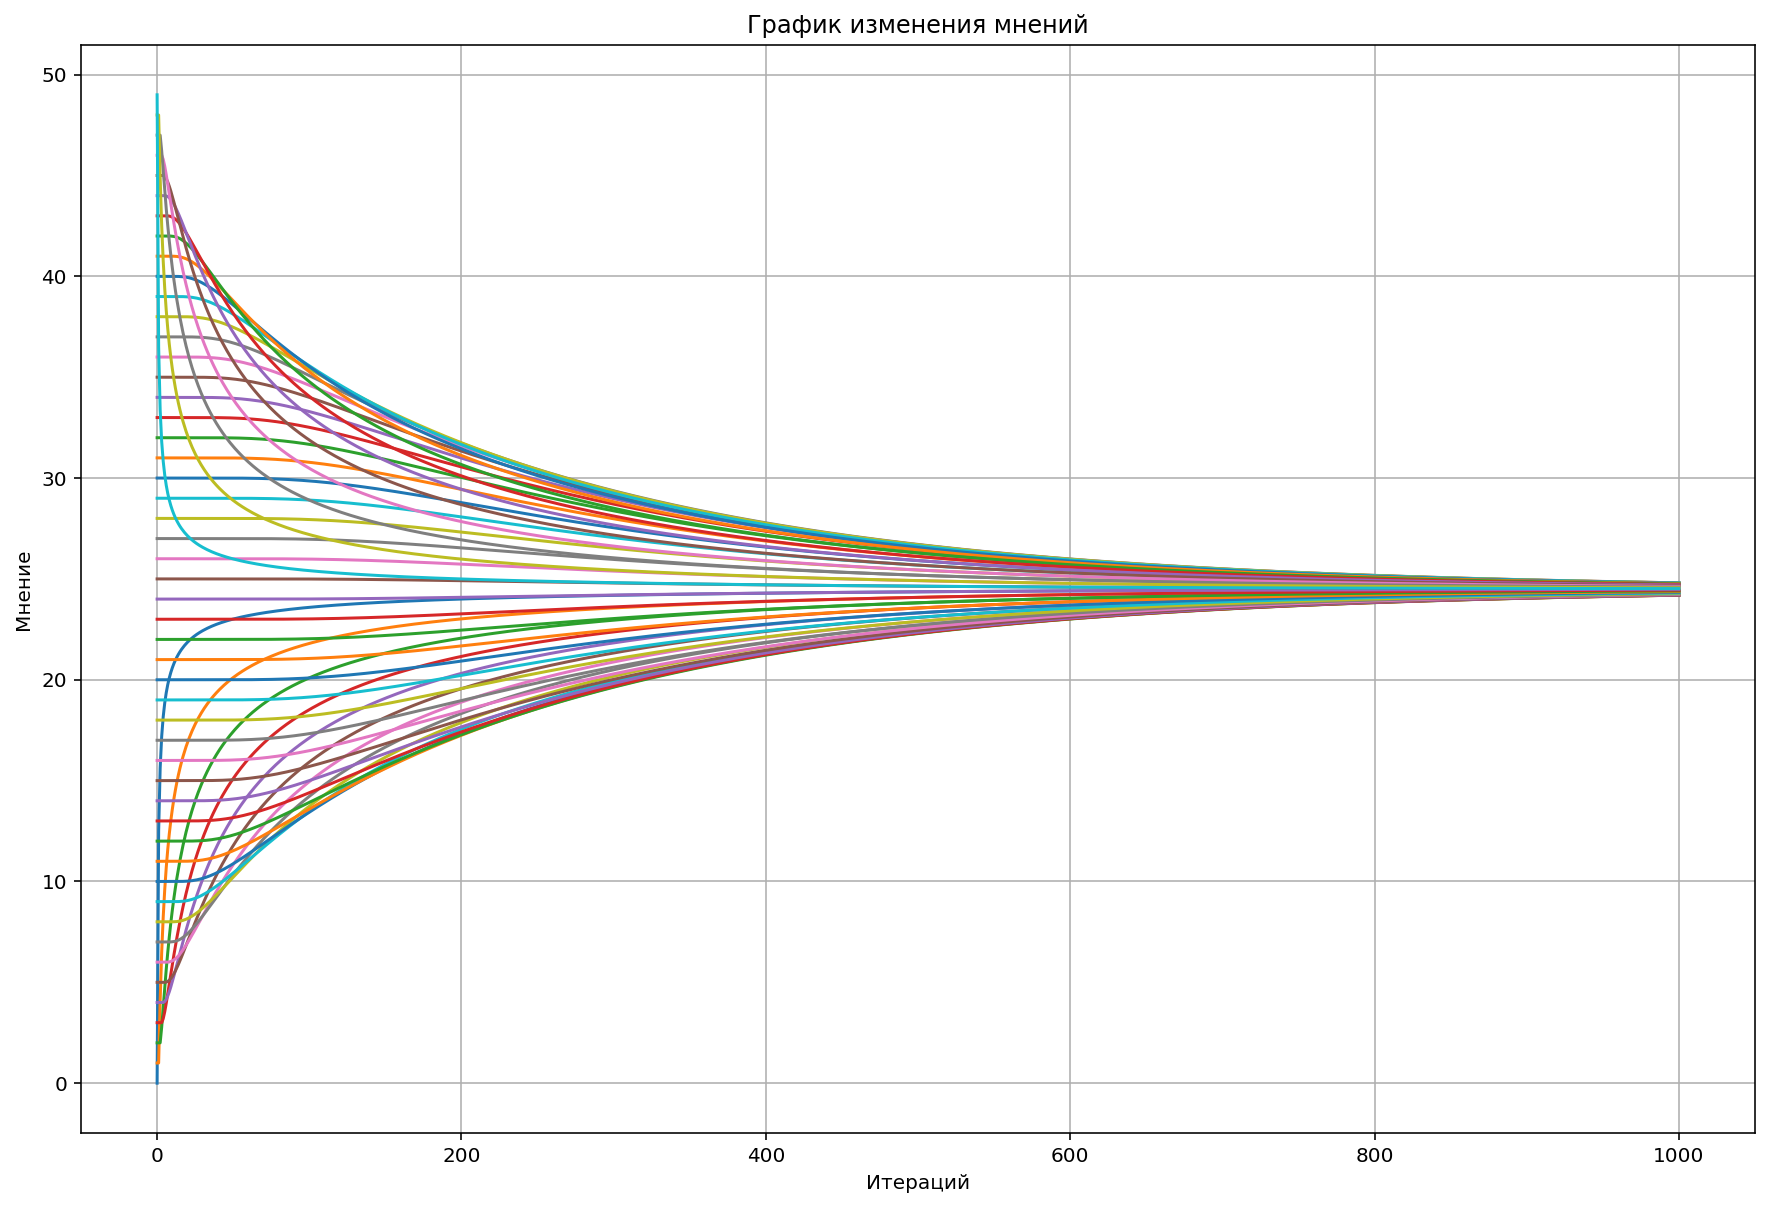

In [14]:
size_of_network = 50
opinion_start = np.arange(size_of_network)
influence_matrix = np.full(shape=(size_of_network,size_of_network),fill_value=0,dtype=float)
np.fill_diagonal(influence_matrix, influence_matrix.diagonal() + 0.5)
for i in range(size_of_network):
    try:
        influence_matrix[i][i-1] = 0.5
        influence_matrix[i][i-1] = 0.25
        influence_matrix[i][i+1] = 0.25
    except:
        pass
influence_matrix[size_of_network-1][0] = 0.25

number_of_iterations = 1000
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 9
50 участников в сети. 

Пусть социальная сеть - звезда

* Центр доверяет себе $\alpha_{1,1} = 1$
* Каждый из остальных доверяет себе с $\alpha_{i,i} = 0.5$ и центру с $\alpha_{i,1} = 0.5$


Итоговое мнение участников будет единым для всех будет равным $$X = x_1^0$$

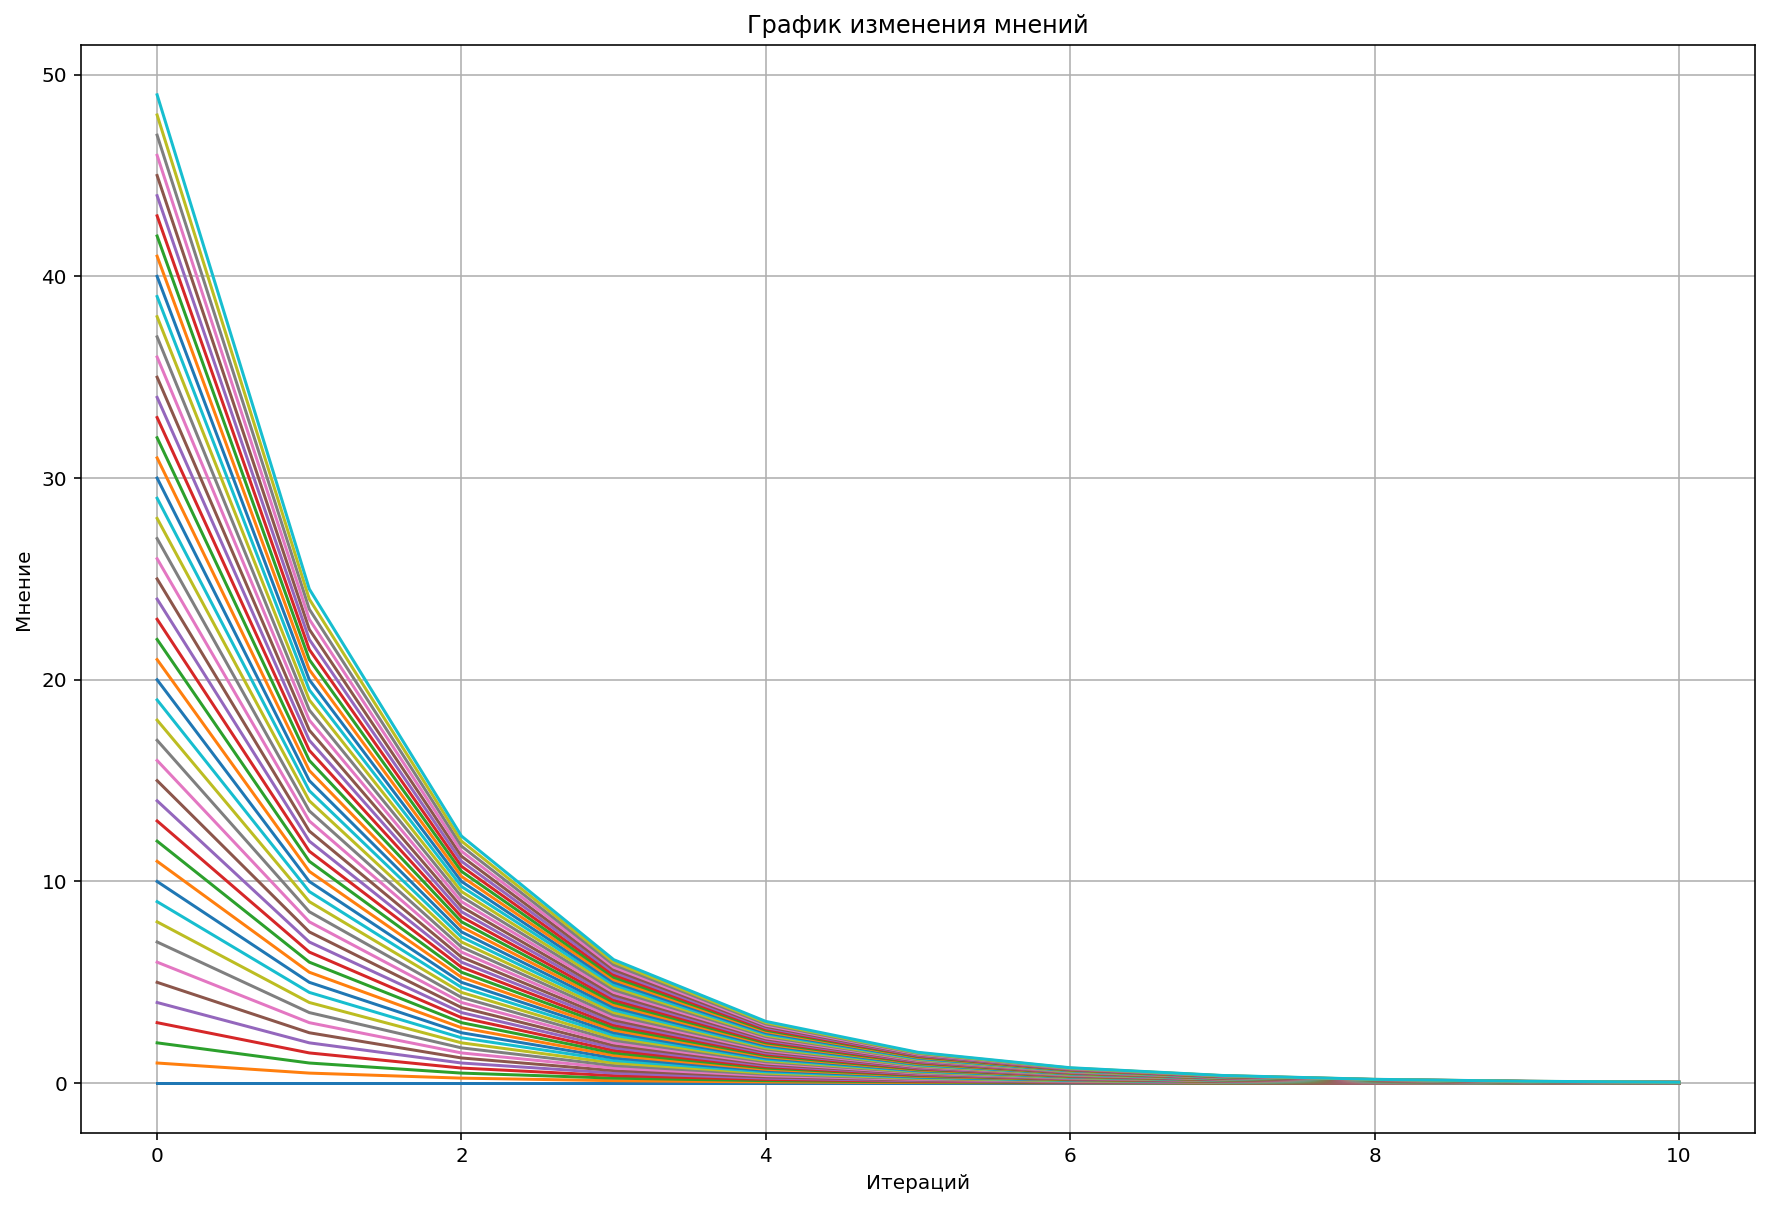

In [15]:
size_of_network = 50
opinion_start = np.arange(size_of_network)
influence_matrix = np.full(shape=(size_of_network,size_of_network),fill_value=0,dtype=float)
np.fill_diagonal(influence_matrix, influence_matrix.diagonal() + 0.5)
for i in range(size_of_network):
    try:
        influence_matrix[i][0] = 0.5

    except:
        pass
influence_matrix[0][0] = 1

number_of_iterations = 10
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 10
50 участников в сети. 

Пусть социальная сеть - полный граф

* Каждый из участников доверяет себе с $\alpha_{i,i} = 0.5$ и всем другим с $\alpha_{i,1} = 0.5/(n-1)$

Итоговое мнение участников будет единым для всех будет равным $$X = \frac{1}{n} \sum_{i=1}^{n}x_i^0$$

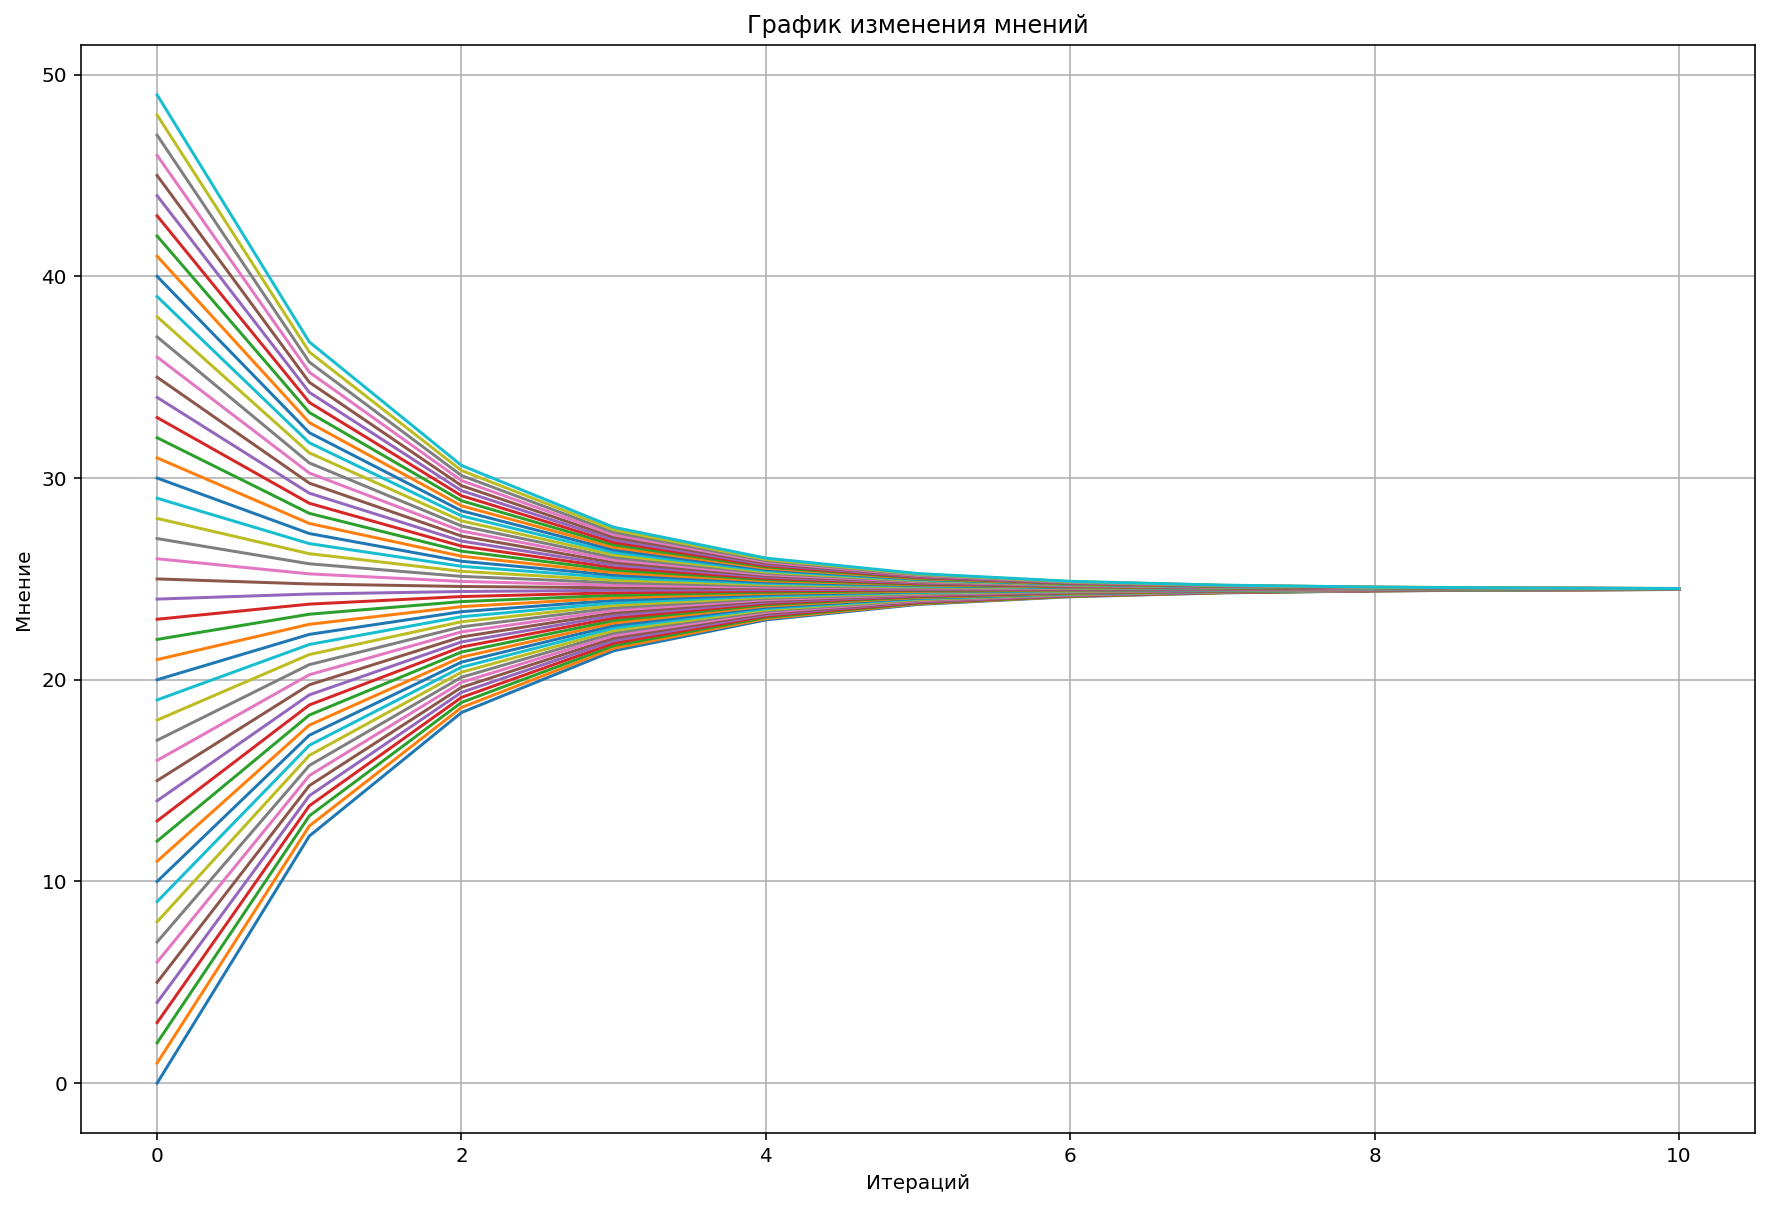

In [16]:
size_of_network = 50
opinion_start = np.arange(size_of_network)
influence_constant = 0.5 / size_of_network
influence_matrix = np.full(shape=(size_of_network,size_of_network),fill_value=0,dtype=float)
for i in range(size_of_network):
    for j in range(size_of_network):
        try:
            influence_matrix[i][j] = influence_constant

        except:
            pass
np.fill_diagonal(influence_matrix, influence_matrix.diagonal() + 0.5)
# print(np.sum(influence_matrix[0]))
number_of_iterations = 10
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 11
50 участников в сети. 

Пусть социальная сеть - звезда с тремя центрами

* Центр доверяет себе $\alpha_{i,i} = 0.34$
* Внутри центра все доверяют другу с вероятностью 0.33
* Каждый из остальных доверяет себе с $\alpha_{i,i} = 0.22$ и центру с $\alpha_{i,j} = 0.26$


Итоговое мнение участников будет единым для всех будет равным средним мнением центра звезды

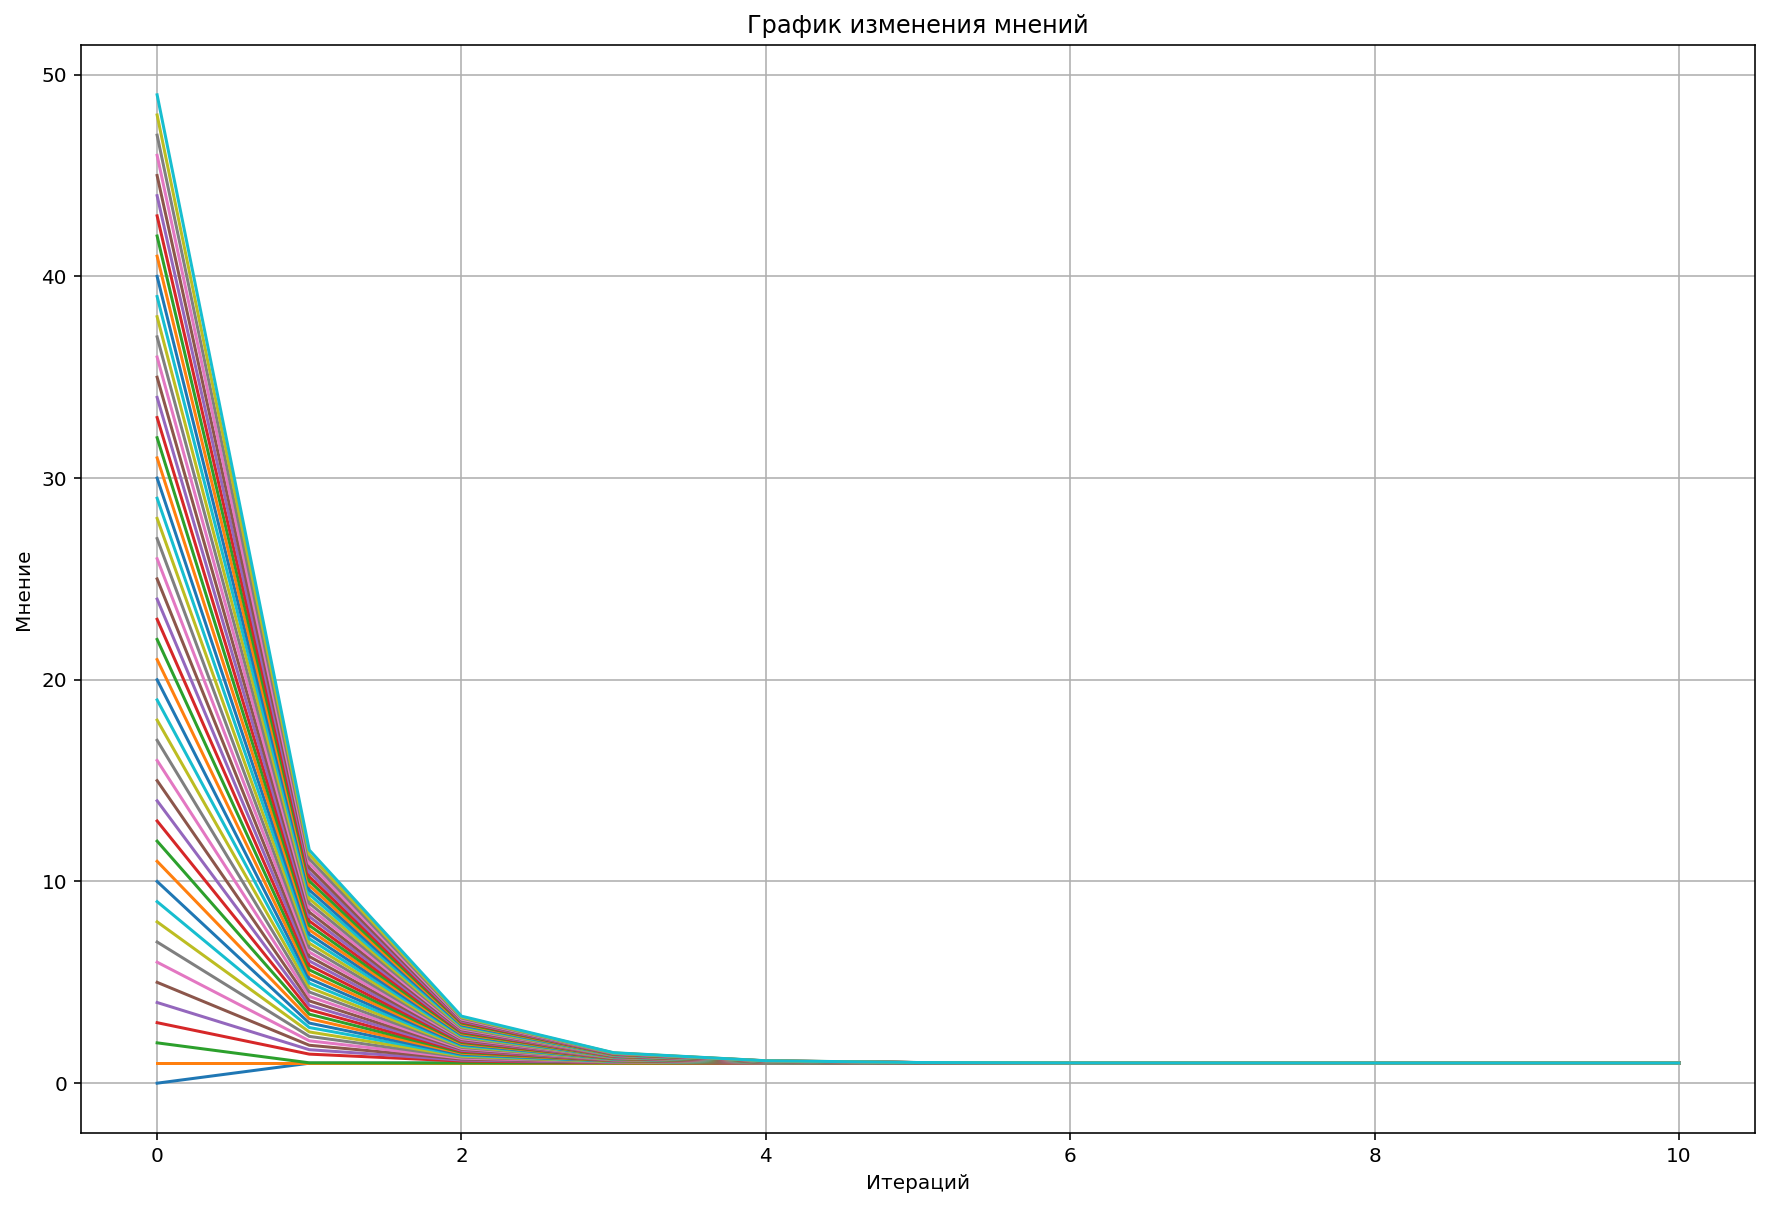

In [17]:
size_of_network = 50
opinion_start = np.arange(size_of_network)

influence_matrix = np.full(shape=(size_of_network,size_of_network),fill_value=0,dtype=float)
np.fill_diagonal(influence_matrix, influence_matrix.diagonal() + 0.22)
for i in range(size_of_network):
    try:
        influence_matrix[i][0] = 0.26
        influence_matrix[i][1] = 0.26
        influence_matrix[i][2] = 0.26

    except:
        pass
for i in range(3):
    for j in range(3):
        influence_matrix[i][j] = 0.33
    influence_matrix[i][i] = 0.34
# print(influence_matrix)

number_of_iterations = 10
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Пример 12
50 участников в сети. 

Пусть социальная сеть - полный граф

* У всех учатников разное мнение
* Начальная матрица влияний составлена из случайных чисел из распределения Дирихле


Итоговое мнение участников будет единым для всех будет равным средним мнением всех

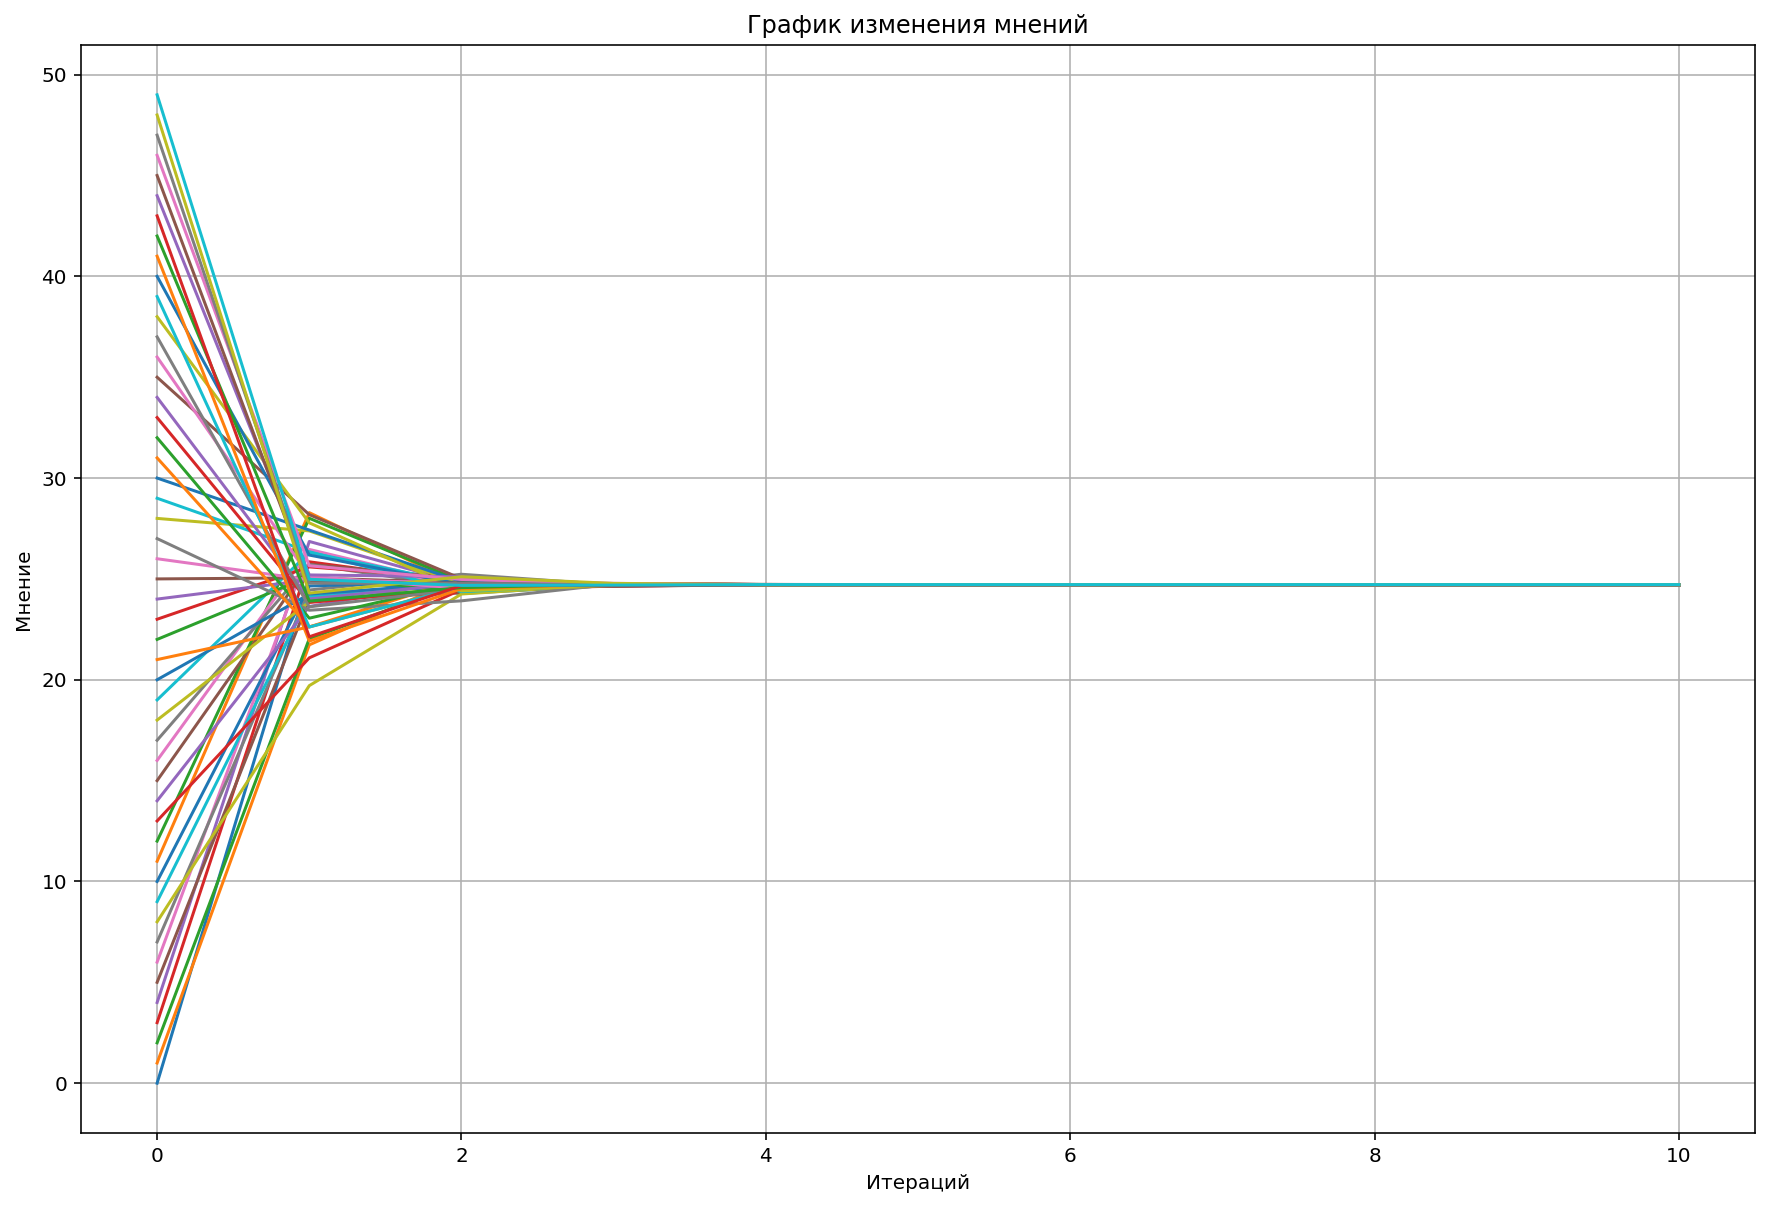

In [18]:
size_of_network = 50
opinion_start = np.arange(size_of_network)
influence_matrix = np.random.dirichlet(np.ones(size_of_network),size=size_of_network)

number_of_iterations = 10
result = conduct_experiment(opinion_start,influence_matrix,number_of_iterations)
visualize_opinion_change(result)

### Вывод

В работе были рассмотрены подходы к моделированию распространения информации в сети и изменение мнений участников этой сети о информации, а также рассмотрено большое количество примеров.

Были получены модели, которые отражают положение дел в реальных ситуациях и согласуются с выводами поведенческой психологии

### Источники 
* M.Cha,H.Haddadi,F.Benevenuto. Measuring User Influence in Twitter
* M.Goetz, J.Leskovec,M.Mcglohon. Modeling blog dynamics 
* J.Daley, G Kendall. Stochastic rumors
* M.Granovetter, Thereshold Models of Collective Behaviour 